# Table Of Contents

Representations learned from Contrastive Learning before Supervised Fine-Tuning

Click to Skip to Histograms Aggregating the Following Attributes:

* [Scene](#Scene-Counts-Per-Cluster)
* [Action](#Action-Class-Counts-Per-Cluster)
* [Person ID](#Person-ID-Counts-Per-Cluster)

[GradCam](#Grad-Cam)


In [1]:
import os
import numpy as np

with open('experiments.txt', 'r') as f:
    experiments=[line.split('\n')[0] for line in f]
len(experiments)


308

In [2]:
import torch
from models import video_resnet, contrastive_model
from torchvision import transforms
import pickle
from Data.spatial_transforms import (
    Compose, Normalize, Scale, CenterCrop, CornerCrop, MultiScaleCornerCrop,
    MultiScaleRandomCrop, RandomHorizontalFlip, ToTensor)
from Data.NTUARD_Dataset_Train import NTUARD_TRAIN
import numpy as np

def get_unique_per_cluster(meta_data_func, num_clusters=13):
    running_sum = 0
    for cluster_label in range(num_clusters):
        running_sum+=len(set(meta_data_func(cluster_label)))
    return running_sum/num_clusters
def _init_backbone(num_classes):
    model = video_resnet.r3d_18(num_classes=num_classes, endpoint='fc', positional_flag = 1)
    return model

def build_mlp(in_features, repr_size):
    import torch.nn as nn
    hidden = nn.Linear(in_features=in_features, out_features=in_features)
    output_layer = nn.Linear(in_features=in_features, out_features=repr_size)

    return nn.Sequential(hidden, nn.ReLU(), output_layer)

def get_base_model(exp_name, contrastive, pre_fine_tuning, view_classification=False, dere=False, visualizations=False):
    if contrastive:
        if view_classification:
            base_model = contrastive_model.ContrastiveDecoderModelWithViewClassification(_init_backbone, 128, False, joint_training=False, varA=False)
        elif dere:
            base_model = contrastive_model.ContrastiveDeRecompositionModel(_init_backbone, 128)

        else:
            base_model = contrastive_model.ContrastiveModel(_init_backbone, repr_size=128, visualizations=visualizations)
            if not pre_fine_tuning:
                base_model.eval_finetune(finetune=True, endpoint='A', num_classes=60)

    elif dere:
        base_model = contrastive_model.DeRecompositionModel(_init_backbone, repr_size=128, action_classes_size=60, decoder_type='resnet', num_frames=8)
    else:
        base_model = video_resnet.r3d_18(endpoint='fc', positional_flag = 1)
    loaded_model = torch.load(f'./results/{exp_name}/model_best.pth.tar')
    if 'best_acc' in loaded_model.keys():
        print(loaded_model['best_acc'])
    base_model.load_state_dict(loaded_model['state_dict'])
    return base_model

def get_ntuard(root='Data', frames_path='/datasets/NTU-ARD/frames-240x135', num_clips=1, num_frames=8, cross_subject=False, norm=True, normal_mean=(0.5, 0.5,0.5), normal_std=(0.5, 0.5, 0.5)):
    
    ## augmentations
    crop_scales = [1.0]
    for _ in range(1, 5):
        crop_scales.append(crop_scales[-1] * 0.84089641525)  ##smallest scale is 0.5

    transformations = [Scale(136), CenterCrop(112), ToTensor(1)]
    #transformations = [ToTensor(1)]

    if norm:
        transformations.append(transforms.Normalize(mean=normal_mean, std=normal_std))
    transform_train = Compose(transformations)

    transform_val = Compose(transformations)

    train_dataset = NTUARD_TRAIN(root=root, train=True, fold=1, num_frames=num_frames, cross_subject=cross_subject, transform=transform_train,
                                 num_clips=num_clips, frames_path=frames_path, args=None, pseudo_label=False)
    test_dataset = NTUARD_TRAIN(root=root, train=False, fold=1, num_frames=num_frames, cross_subject=cross_subject, transform=transform_val, num_clips=num_clips, frames_path=frames_path, args=None)

    return train_dataset, test_dataset

# get data
def get_sampled_targets(dataset, number_samples, num_limited_targets):
    itemize_index_by_target = {i:[] for i in range(1,61)}

    for i, target in enumerate(dataset.targets):
        if target <= num_limited_targets:
            itemize_index_by_target[target].append(i)
    
    sampled_targets = []
    for indicies in itemize_index_by_target.values():
        if len(indicies) > 0:
            sampled_targets.extend(np.random.choice(indicies, number_samples))
    return sampled_targets, itemize_index_by_target



# T-SNE Visualizations 

In [7]:
import psutil
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import random
import numpy as np
import einops

seed = 10
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

class NTUARD_MetaData:
    def __init__(self, scene, action, pid, rid, view):
        self.scene=scene
        self.action=action
        self.pid=pid
        self.rid=rid
        self.view=view
def get_tsne_representations(base_model, sampled_targets, test_dataset, get_bias_repr=False, eval_mode=False):
    base_model.fc = None
    base_model.eval_mode = None
    base_model.cuda()
    representations = []
    respective_targets = []
    meta_data = []

    base_model.eval()
    for counter, i in enumerate(sampled_targets):
        data, target = test_dataset.__getitem__(i)
        other_metadata, view = test_dataset.video_paths[i]['path'].split("/")[-2:]
        scene, pid, rid, action = test_dataset._decrypt_vid_name(other_metadata)
        meta_data.append(NTUARD_MetaData(scene, action, pid, rid, int(view)))
        respective_targets.append(target)
        with torch.no_grad():
            base_model.eval_mode=eval_mode
            output = base_model(data.cuda())
            if len(output) == 4:
                compressed_repr, generated_output, contrastive_repr, view_classification = output
                output = contrastive_repr
            elif len(output) == 2:
                contrastive_repr, bias_repr = output
                if get_bias_repr:
                    output = bias_repr
                else:
                    output = contrastive_repr
            output = output.squeeze()
            if len(output.shape) == 2:
                output = einops.reduce(output, 'c repr -> repr','mean')
            representations.append(output.squeeze().cpu().numpy())        
    representations = np.array(representations)
    tsne = TSNE(n_components=2).fit_transform(representations)
    return tsne, respective_targets, meta_data

In [8]:
# SOURCE: https://learnopencv.com/t-sne-for-feature-visualization/
def get_visualizations(tsne, num_limited_targets, respective_targets):
# scale and move the coordinates so they fit [0; 1] range
    def scale_to_01_range(x):
        # compute the distribution range
        value_range = (np.max(x) - np.min(x))
        # move the distribution so that it starts from zero
        # by extracting the minimal value from all its values
        starts_from_zero = x - np.min(x)
        # make the distribution fit [0; 1] by dividing by its range
        return starts_from_zero / value_range

    # extract x and y coordinates representing the positions of the images on T-SNE plot
    tx = tsne[:, 0]
    ty = tsne[:, 1]

    tx = scale_to_01_range(tx)
    ty = scale_to_01_range(ty)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    sns.palplot(sns.color_palette("muted"))
    rgb_values = sns.color_palette("husl", num_limited_targets)
    colors_per_class = dict(zip(list(range(1,num_limited_targets+1)), rgb_values))
    # for every class, we'll add a scatter plot separately
    idx = 0
    for label in colors_per_class:
        if idx == num_limited_targets:
            break
        else:
            idx+=1
        # find the samples of the current class in the data
        indices = [i for i, l in enumerate(respective_targets) if l == label]
        # extract the coordinates of the points of this class only
        current_tx = np.take(tx, indices)
        current_ty = np.take(ty, indices)
        # convert the class color to matplotlib format
        color = colors_per_class[label]
        # add a scatter plot with the corresponding color and label
        ax.scatter(current_tx, current_ty, color=color, label=label)

    # build a legend using the labels we set previously
    ax.legend(loc='best')

    # finally, show the plot
    plt.show()


In [79]:
### PARAMS ####
contrastive = True
pre_fine_tuning = True
view_classification = False
#exp_name = 'cv_same_timepoint_eval_single_clip_100contrastive_endpoint_A_finetune_TrueFalse'
exp_name = 'cross_view_contrastive_same_timepointresnet3D1832128_False_clips_1_lr_0.02augmentFalse'
#exp_name = 'supervised_CV_10resnet3D181616_False_clips_1_gru_False_CS_False'
#exp_name = 'view_classificationresnet3D183264_False_clips_1_lr_0.002augmentFalse'
### PARAMS FOR VISUALIZATION ###
view_only_viz = False
number_samples = 50
num_limited_targets = 20
#compressed_repr, generated_output, contrastive_repr, view_classification

In [86]:
base_model = get_base_model(exp_name, contrastive, pre_fine_tuning, visualizations=True)

train_dataset, test_dataset = get_ntuard('Data', num_clips=1, cross_subject=False, normal_mean=0.5, normal_std=0.5)
sampled_targets, itemize_index_by_target = get_sampled_targets(test_dataset, number_samples)

tsne, respective_targets, meta_data = get_tsne_representations(base_model, sampled_targets, test_dataset)

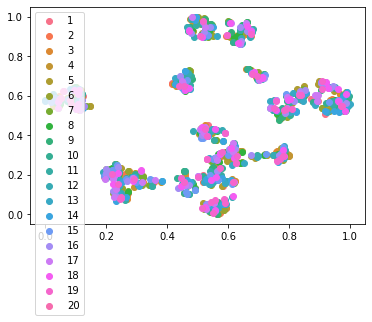

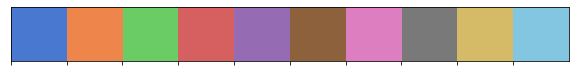

In [87]:
get_visualizations(tsne, num_limited_targets, respective_targets)

# Clustering the representations and Meta Data Histograms

In [88]:
from sklearn.cluster import KMeans
def get_subset_arr(arr, label, d):
    indicies = d[label]
    return [arr[i] for i in indicies]

def get_clusters(tsne, k=13):
    #histogram

    kmeans_model = KMeans(n_clusters=k, random_state=1).fit(tsne)
    labels = kmeans_model.labels_



    indicies_per_cluster_label = {l:[] for l in set(labels)}
    for i, label in enumerate(labels):
        indicies_per_cluster_label[label].append(i)
    return labels, indicies_per_cluster_label

In [89]:
labels, indicies_per_cluster_label = get_clusters(tsne)

## Scene Counts Per Cluster

Cluster 0


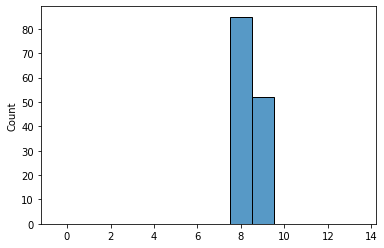

Cluster 1


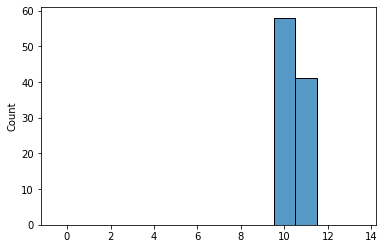

Cluster 2


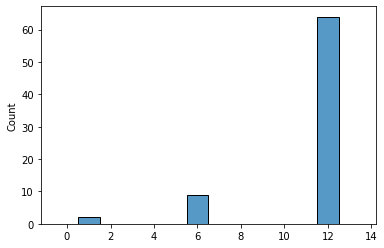

Cluster 3


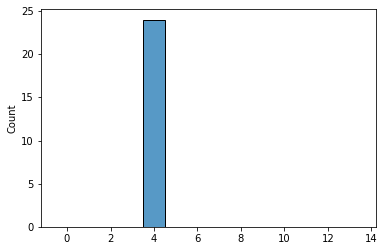

Cluster 4


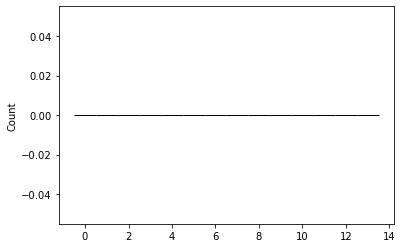

Cluster 5


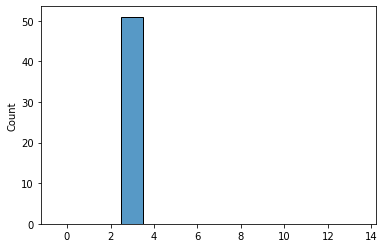

Cluster 6


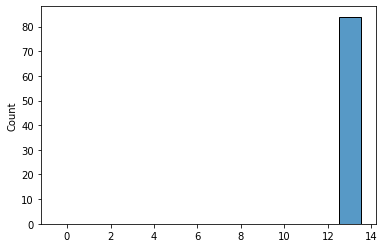

Cluster 7


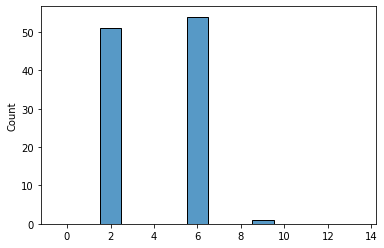

Cluster 8


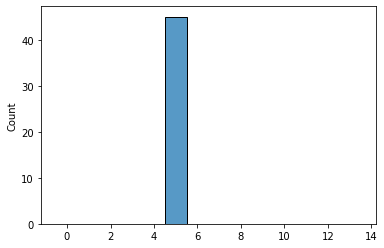

Cluster 9


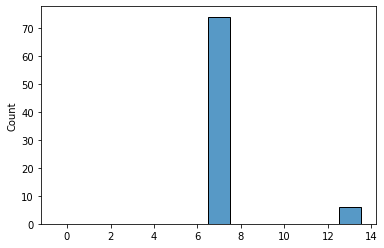

Cluster 10


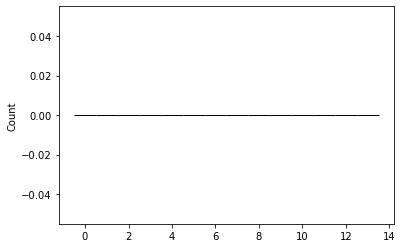

Cluster 11


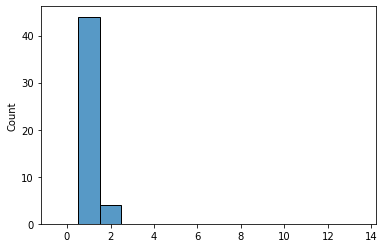

Cluster 12


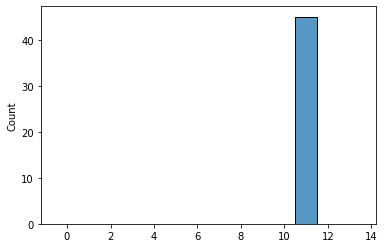

In [113]:
for cluster_label in indicies_per_cluster_label.keys():
    print("Cluster", cluster_label)
    sns.histplot([m.scene for i, m in \
                  enumerate(get_subset_arr(meta_data, cluster_label, \
                                           indicies_per_cluster_label))] , discrete=1, stat="count", binrange=(0,13))
    plt.show()


## Action Class Counts Per Cluster

Cluster 0


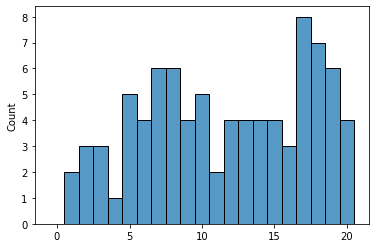

Cluster 1


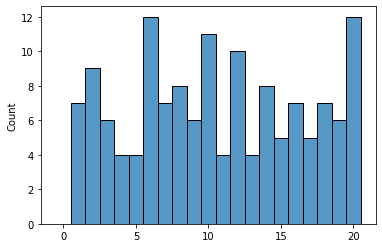

Cluster 2


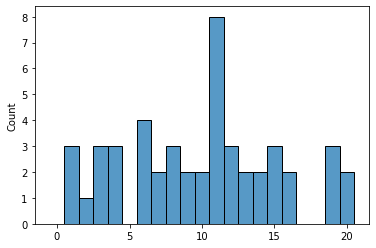

Cluster 3


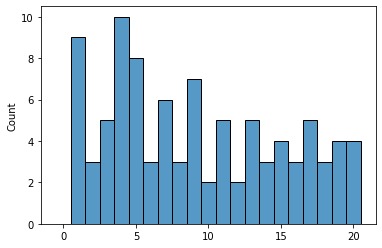

Cluster 4


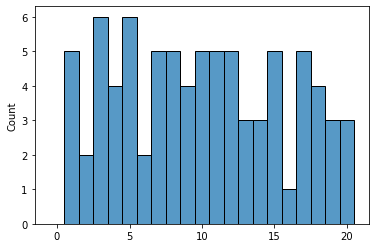

Cluster 5


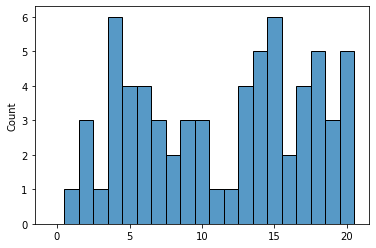

Cluster 6


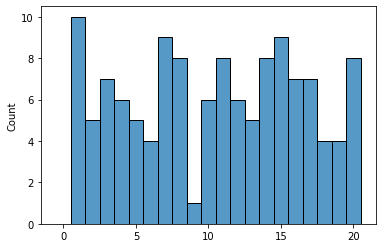

Cluster 7


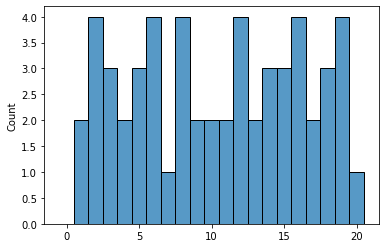

Cluster 8


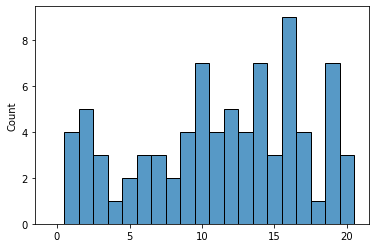

Cluster 9


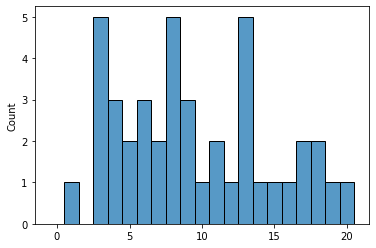

Cluster 10


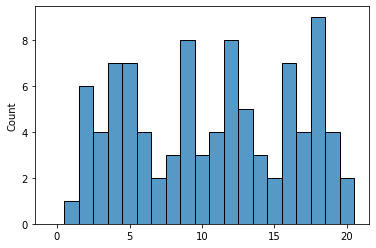

Cluster 11


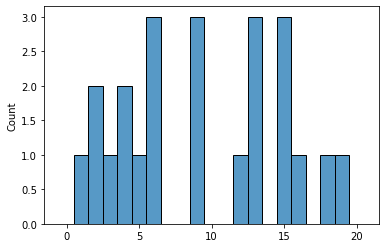

Cluster 12


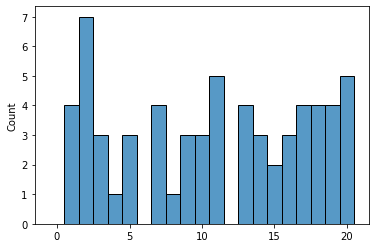

In [16]:
for cluster_label in indicies_per_cluster_label.keys():
    print("Cluster", cluster_label)
    sns.histplot([m.action for i, m in \
                  enumerate(get_subset_arr(meta_data, cluster_label, \
                                           indicies_per_cluster_label))] , discrete=1, stat="count", binrange=(0,20))
    plt.show()


## Person ID Counts Per Cluster

Cluster 0


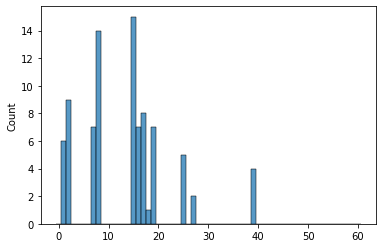

Cluster 1


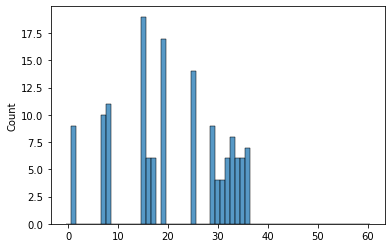

Cluster 2


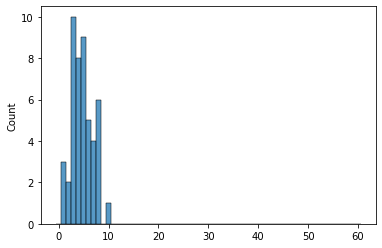

Cluster 3


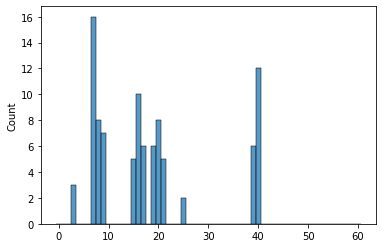

Cluster 4


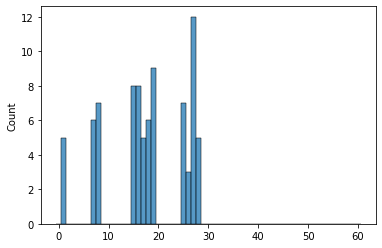

Cluster 5


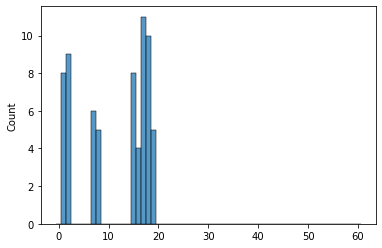

Cluster 6


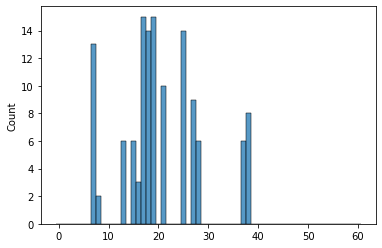

Cluster 7


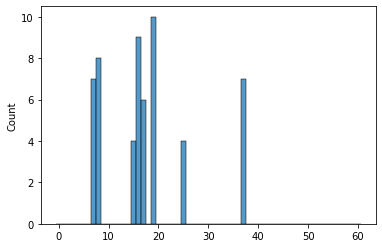

Cluster 8


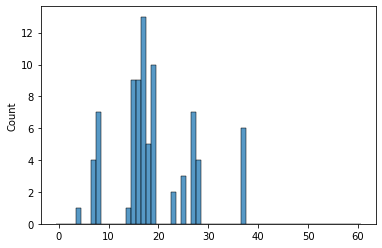

Cluster 9


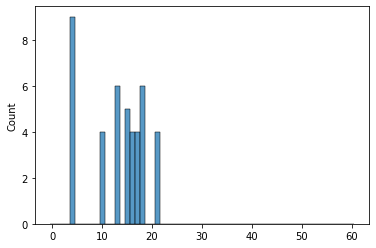

Cluster 10


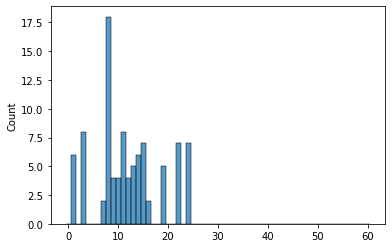

Cluster 11


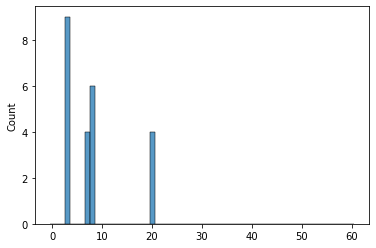

Cluster 12


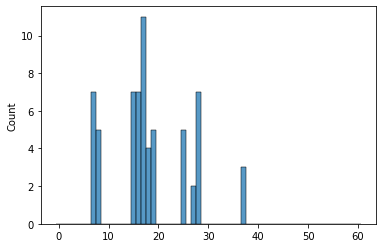

In [15]:
for cluster_label in indicies_per_cluster_label.keys():
    print("Cluster", cluster_label)
    sns.histplot([m.pid for i, m in \
                  enumerate(get_subset_arr(meta_data, cluster_label, \
                                           indicies_per_cluster_label))] , discrete=1, stat="count", binrange=(0,60))
    plt.show()


In [90]:
unique_scenes = get_unique_per_cluster(lambda cluster_label: [m.scene for i, m in \
                  enumerate(get_subset_arr(meta_data, cluster_label, \
                                           indicies_per_cluster_label))])
print("average unique_scenes", unique_scenes)
unique_actions = get_unique_per_cluster(lambda cluster_label: [m.action for i, m in \
                  enumerate(get_subset_arr(meta_data, cluster_label, \
                                           indicies_per_cluster_label))])
print("average unique_actions", unique_actions)
unique_persons = get_unique_per_cluster(lambda cluster_label: [m.pid for i, m in \
                  enumerate(get_subset_arr(meta_data, cluster_label, \
                                           indicies_per_cluster_label))])
print("average unique_pid", unique_persons)

average unique_scenes 2.1538461538461537
average unique_actions 19.692307692307693
average unique_pid 11.153846153846153


# Contrastive + View Classification Visualizations

In [50]:
### PARAMS ####
contrastive = True
pre_fine_tuning = True
view_classification = True
#exp_name = 'cv_same_timepoint_eval_single_clip_100contrastive_endpoint_A_finetune_TrueFalse'
#exp_name = 'cross_view_contrastive_same_timepointresnet3D1832128_False_clips_1_lr_0.02augmentFalse'
#exp_name = 'supervised_CV_10resnet3D181616_False_clips_1_gru_False_CS_False'
exp_name = 'view_classificationresnet3D183264_False_clips_1_lr_0.002augmentFalse'
### PARAMS FOR VISUALIZATION ###
view_only_viz = False
number_samples = 50
num_limited_targets = 20

#compressed_repr, generated_output, contrastive_repr, view_classification

In [51]:
base_model = get_base_model(exp_name, contrastive, pre_fine_tuning, view_classification)

train_dataset, test_dataset = get_ntuard('Data', num_clips=1, cross_subject=False, normal_mean=128, normal_std=128)
sampled_targets, itemize_index_by_target = get_sampled_targets(test_dataset, number_samples)

tsne, respective_targets, meta_data = get_tsne_representations(base_model, sampled_targets, test_dataset)

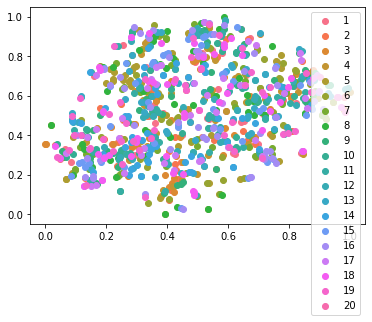

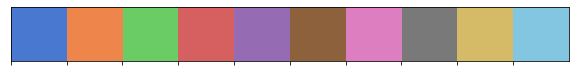

In [52]:
get_visualizations(tsne, num_limited_targets, respective_targets)

In [53]:
labels, indicies_per_cluster_label = get_clusters(tsne)

Cluster 0


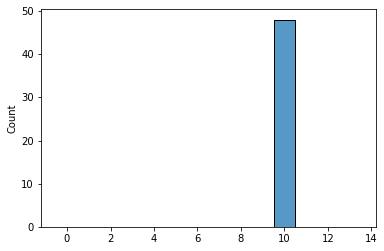

Cluster 1


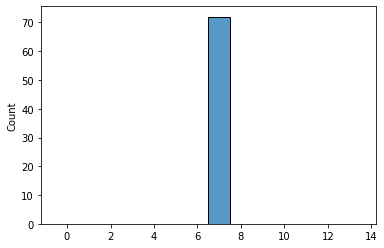

Cluster 2


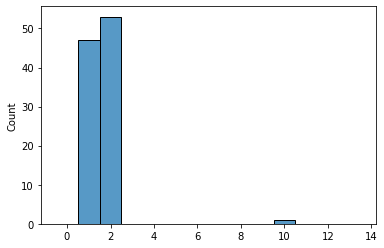

Cluster 3


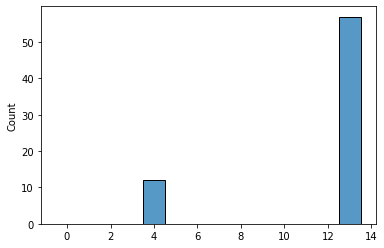

Cluster 4


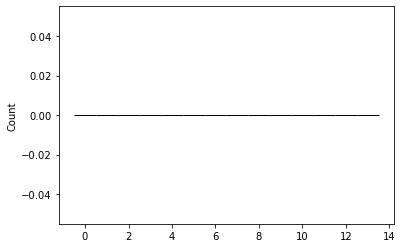

Cluster 5


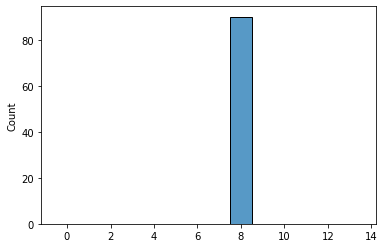

Cluster 6


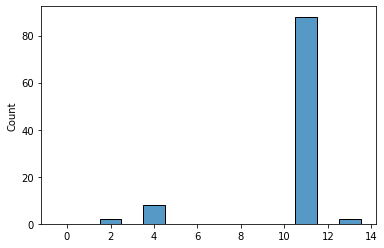

Cluster 7


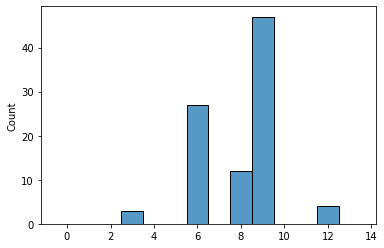

Cluster 8


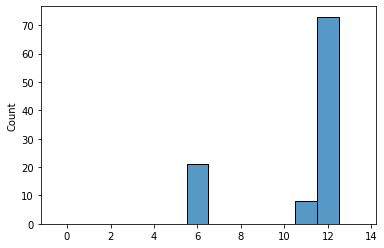

Cluster 9


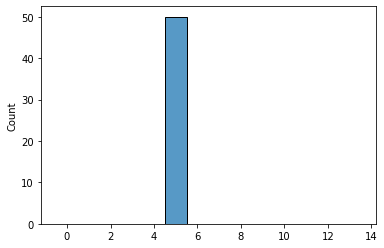

Cluster 10


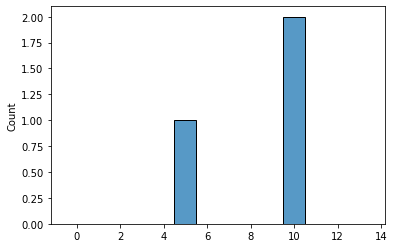

Cluster 11


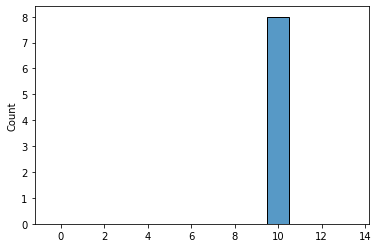

Cluster 12


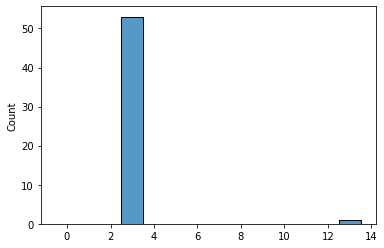

In [42]:
for cluster_label in indicies_per_cluster_label.keys():
    print("Cluster", cluster_label)
    sns.histplot([m.scene for i, m in \
                  enumerate(get_subset_arr(meta_data, cluster_label, \
                                           indicies_per_cluster_label))] , discrete=1, stat="count", binrange=(0,13))
    plt.show()


Cluster 0


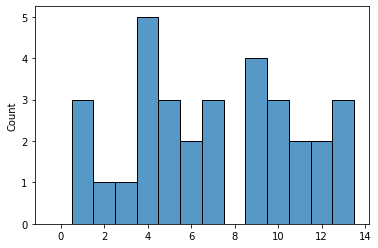

Cluster 1


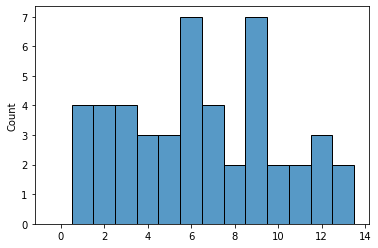

Cluster 2


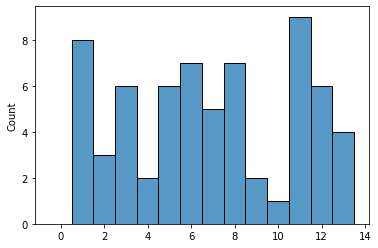

Cluster 3


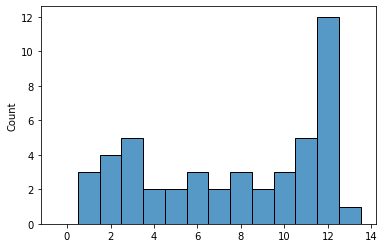

Cluster 4


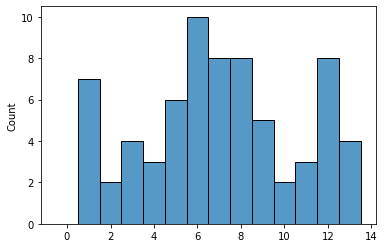

Cluster 5


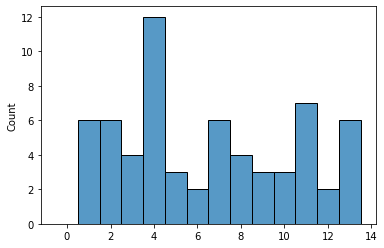

Cluster 6


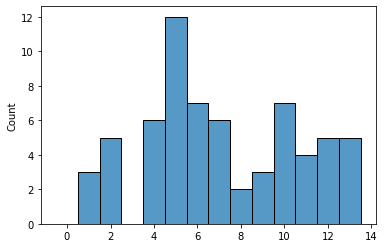

Cluster 7


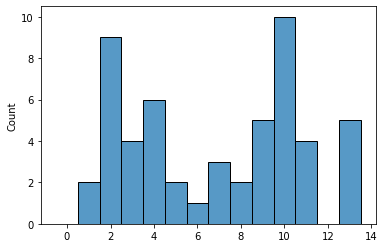

Cluster 8


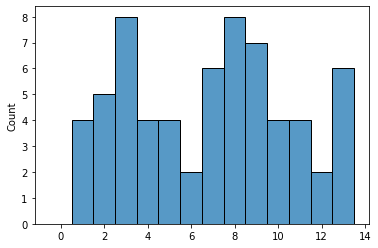

Cluster 9


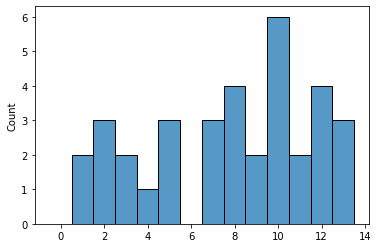

Cluster 10


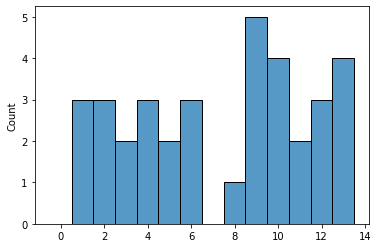

Cluster 11


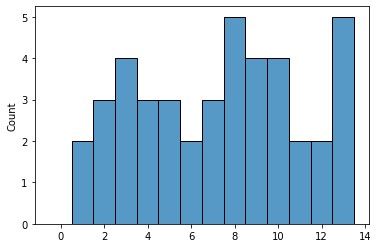

Cluster 12


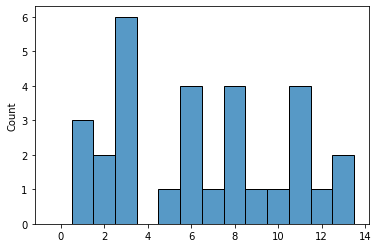

In [43]:
for cluster_label in indicies_per_cluster_label.keys():
    print("Cluster", cluster_label)
    sns.histplot([m.action for i, m in \
                  enumerate(get_subset_arr(meta_data, cluster_label, \
                                           indicies_per_cluster_label))] , discrete=1, stat="count", binrange=(0,13))
    plt.show()

Cluster 0


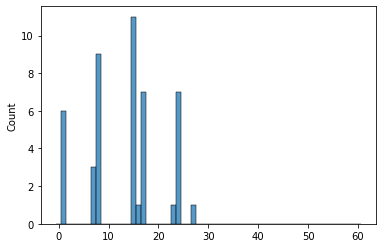

Cluster 1


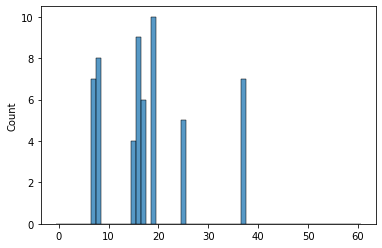

Cluster 2


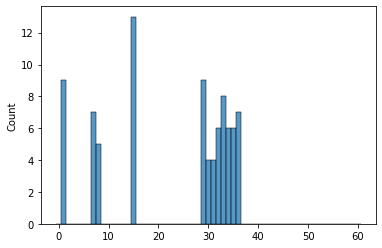

Cluster 3


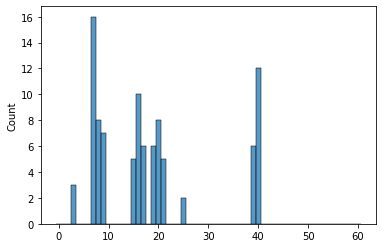

Cluster 4


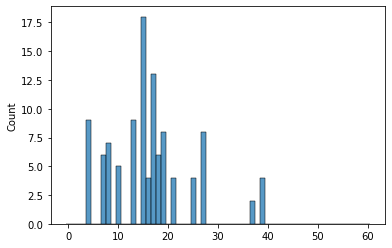

Cluster 5


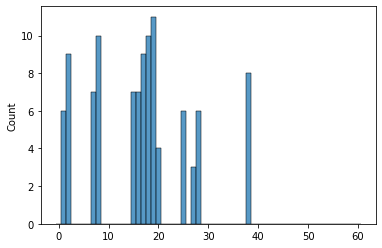

Cluster 6


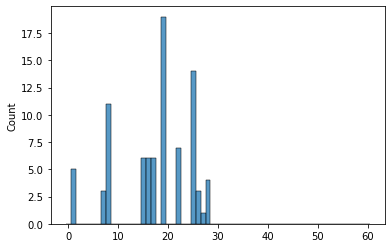

Cluster 7


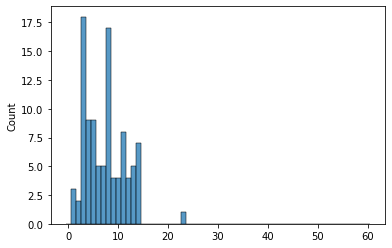

Cluster 8


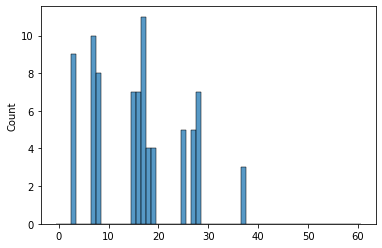

Cluster 9


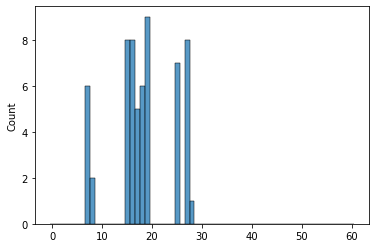

Cluster 10


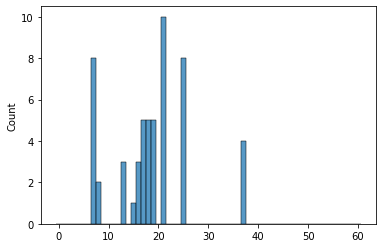

Cluster 11


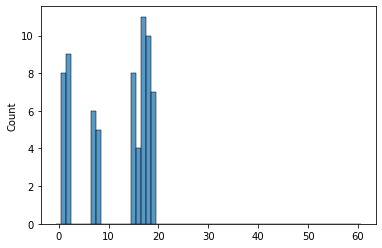

Cluster 12


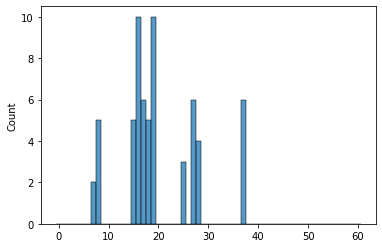

In [11]:
for cluster_label in indicies_per_cluster_label.keys():
    print("Cluster", cluster_label)
    sns.histplot([m.pid for i, m in \
                  enumerate(get_subset_arr(meta_data, cluster_label, \
                                           indicies_per_cluster_label))] , discrete=1, stat="count", binrange=(0,60))
    plt.show()

In [54]:
unique_scenes = get_unique_per_cluster(lambda cluster_label: [m.scene for i, m in \
                  enumerate(get_subset_arr(meta_data, cluster_label, \
                                           indicies_per_cluster_label))])
print("average unique_scenes", unique_scenes)
unique_actions = get_unique_per_cluster(lambda cluster_label: [m.action for i, m in \
                  enumerate(get_subset_arr(meta_data, cluster_label, \
                                           indicies_per_cluster_label))])
print("average unique_actions", unique_actions)
unique_persons = get_unique_per_cluster(lambda cluster_label: [m.pid for i, m in \
                  enumerate(get_subset_arr(meta_data, cluster_label, \
                                           indicies_per_cluster_label))])
print("average unique_pid", unique_persons)

average unique_scenes 6.461538461538462
average unique_actions 19.23076923076923
average unique_pid 14.307692307692308


# Comparing Unique PIDs per Cluster between Contrastive Only and Contrastive+View Classification

Our results show that the contrastive+view classification has a slightly higher number of unqiue persons per cluster compared to the clusters from the contrastive only approach. However, there is room to address this person bias.

In [7]:
def get_unique_per_cluster(meta_data_func, num_clusters=13):
    running_sum = 0
    for cluster_label in range(num_clusters):
        running_sum+=len(set(meta_data_func(cluster_label)))
    return running_sum/num_clusters

## De-Re Composed Reconstruction (Bias)

In [55]:
### PARAMS ####
contrastive = True
pre_fine_tuning = True
view_classification = False
dere = True
get_bias = True
#exp_name = 'cv_same_timepoint_eval_single_clip_100contrastive_endpoint_A_finetune_TrueFalse'
#exp_name = 'cross_view_contrastive_same_timepointresnet3D1832128_False_clips_1_lr_0.02augmentFalse'
#exp_name = 'supervised_CV_10resnet3D181616_False_clips_1_gru_False_CS_False'
exp_name = 'cross_view_dere_contrastive_resnet3D183264_False_clips_1_lr_0.002augmentFalse'
### PARAMS FOR VISUALIZATION ###
view_only_viz = False
number_samples = 50
num_limited_targets = 20

#compressed_repr, generated_output, contrastive_repr, view_classification

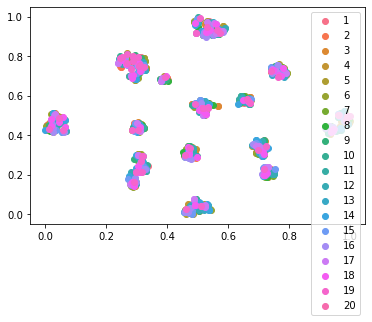

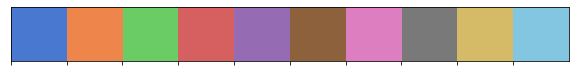

In [56]:
base_model = get_base_model(exp_name, contrastive, pre_fine_tuning, view_classification, dere)

train_dataset, test_dataset = get_ntuard('Data', num_clips=1, cross_subject=False, normal_mean=128, normal_std=128)
sampled_targets, itemize_index_by_target = get_sampled_targets(test_dataset, number_samples)

tsne, respective_targets, meta_data = get_tsne_representations(base_model, sampled_targets, test_dataset, get_bias, eval_mode=True)
get_visualizations(tsne, num_limited_targets, respective_targets)

Cluster 0


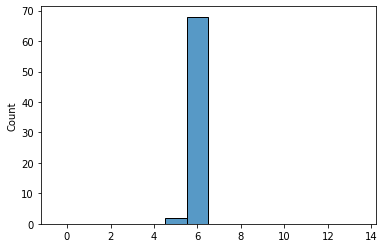

Cluster 1


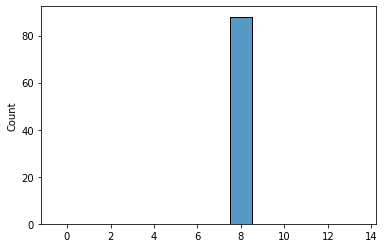

Cluster 2


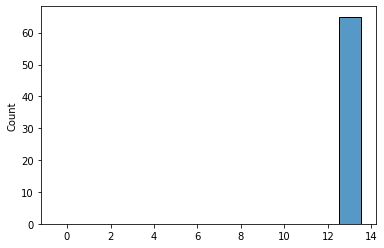

Cluster 3


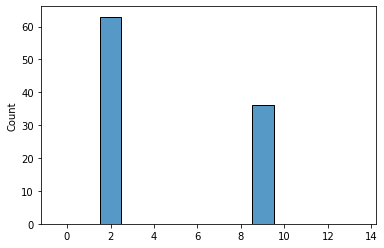

Cluster 4


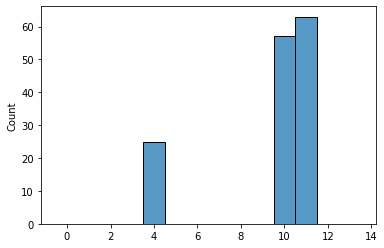

Cluster 5


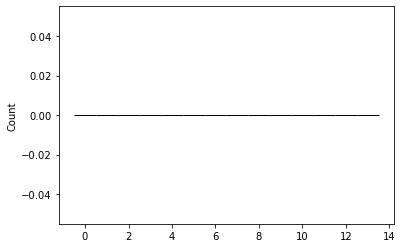

Cluster 6


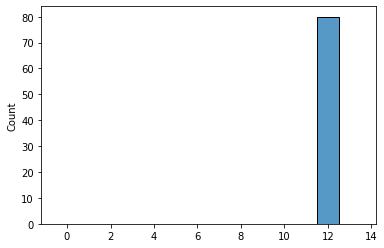

Cluster 7


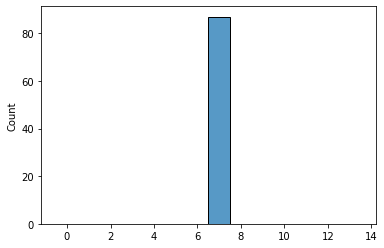

Cluster 8


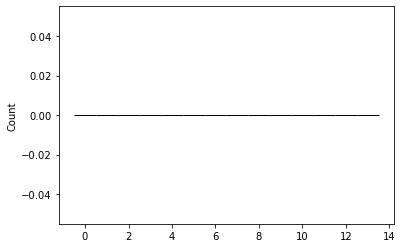

Cluster 9


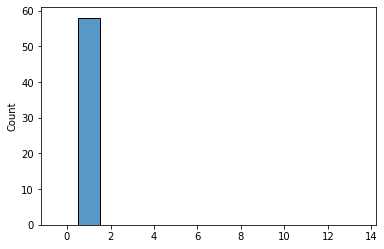

Cluster 10


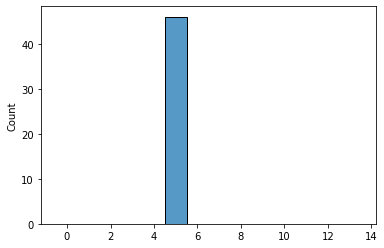

Cluster 11


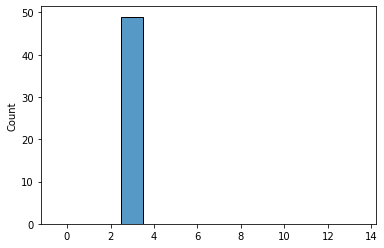

Cluster 12


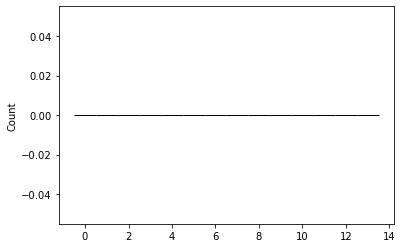

In [57]:
labels, indicies_per_cluster_label = get_clusters(tsne)
for cluster_label in indicies_per_cluster_label.keys():
    print("Cluster", cluster_label)
    sns.histplot([m.scene for i, m in \
                  enumerate(get_subset_arr(meta_data, cluster_label, \
                                           indicies_per_cluster_label))] , discrete=1, stat="count", binrange=(0,13))
    plt.show()


Cluster 0


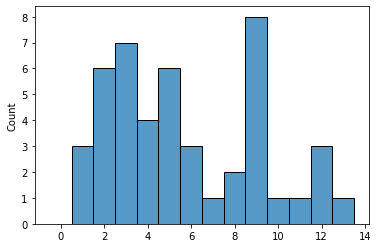

Cluster 1


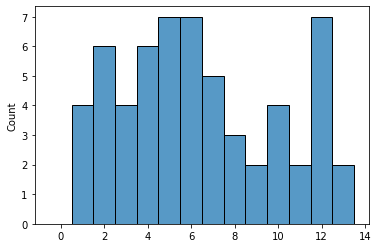

Cluster 2


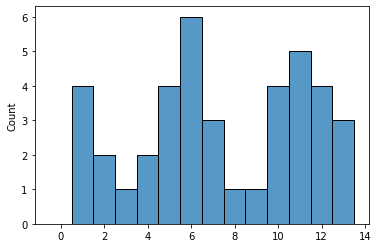

Cluster 3


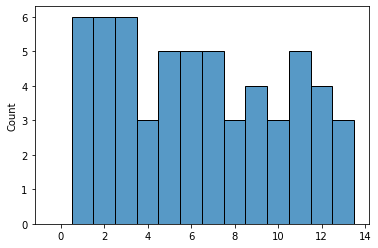

Cluster 4


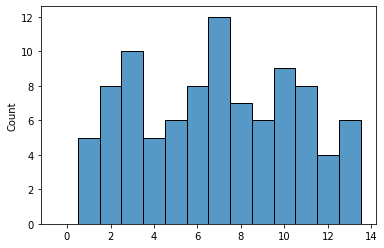

Cluster 5


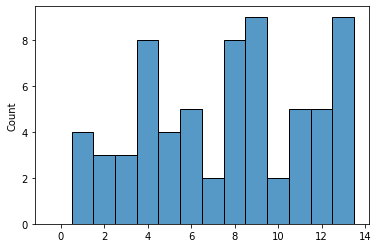

Cluster 6


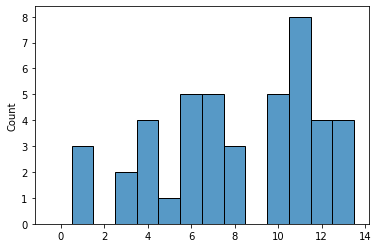

Cluster 7


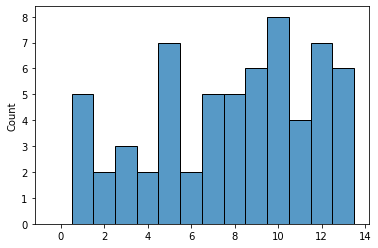

Cluster 8


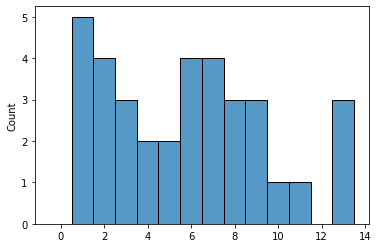

Cluster 9


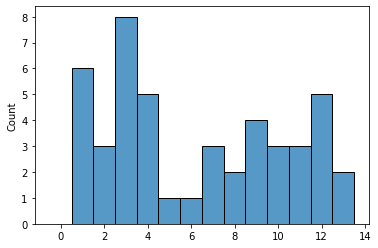

Cluster 10


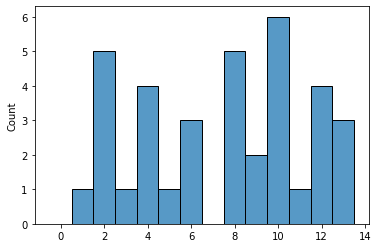

Cluster 11


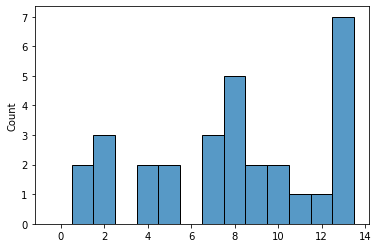

Cluster 12


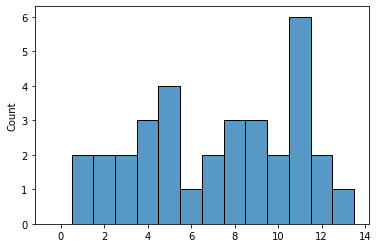

In [58]:
for cluster_label in indicies_per_cluster_label.keys():
    print("Cluster", cluster_label)
    sns.histplot([m.action for i, m in \
                  enumerate(get_subset_arr(meta_data, cluster_label, \
                                           indicies_per_cluster_label))] , discrete=1, stat="count", binrange=(0,13))
    plt.show()

Cluster 0


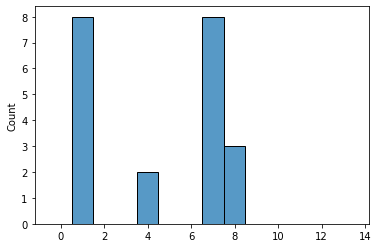

Cluster 1


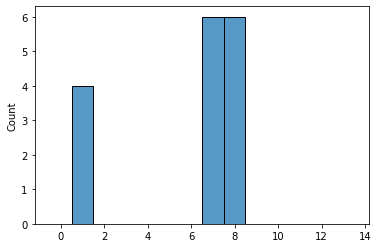

Cluster 2


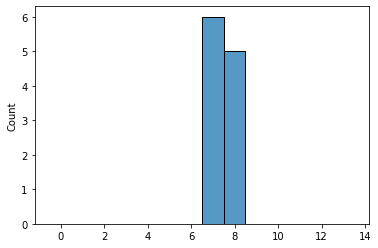

Cluster 3


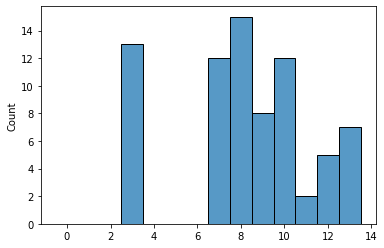

Cluster 4


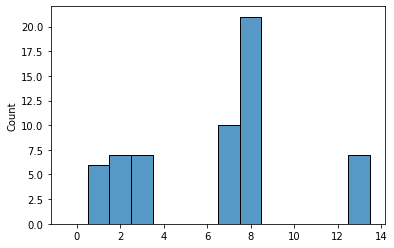

Cluster 5


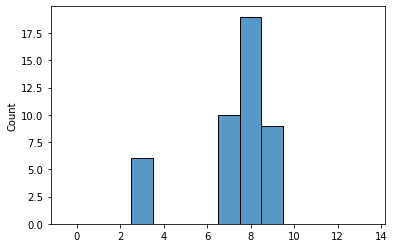

Cluster 6


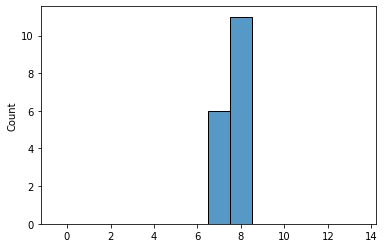

Cluster 7


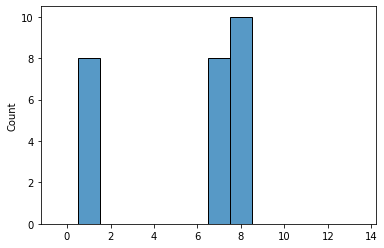

Cluster 8


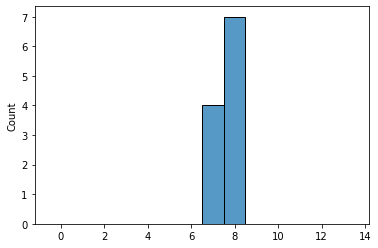

Cluster 9


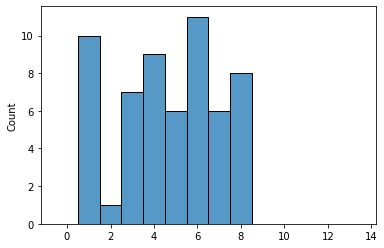

Cluster 10


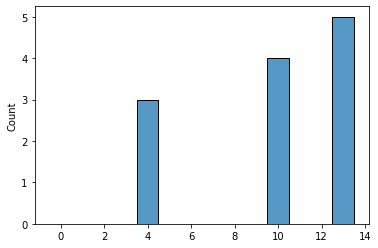

Cluster 11


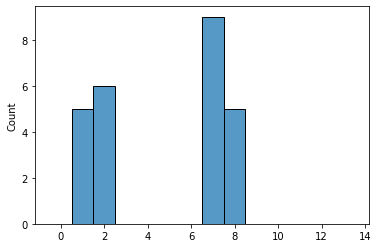

Cluster 12


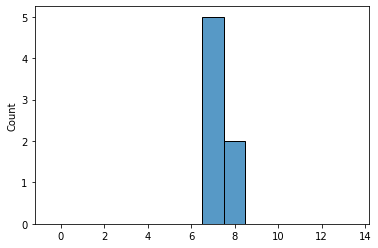

In [59]:
for cluster_label in indicies_per_cluster_label.keys():
    print("Cluster", cluster_label)
    sns.histplot([m.pid for i, m in \
                  enumerate(get_subset_arr(meta_data, cluster_label, \
                                           indicies_per_cluster_label))] , discrete=1, stat="count", binrange=(0,13))
    plt.show()

In [60]:
unique_scenes_dere_contrastive = get_unique_per_cluster(lambda cluster_label: [m.scene for i, m in \
                  enumerate(get_subset_arr(meta_data, cluster_label, \
                                           indicies_per_cluster_label))])
print("average unique_scenes_dere_contrastive", unique_scenes_dere_contrastive)
unique_actions_dere_contrastive = get_unique_per_cluster(lambda cluster_label: [m.action for i, m in \
                  enumerate(get_subset_arr(meta_data, cluster_label, \
                                           indicies_per_cluster_label))])
print("average unique_actions_dere_contrastive", unique_actions_dere_contrastive)
unique_persons_dere_contrastive = get_unique_per_cluster(lambda cluster_label: [m.pid for i, m in \
                  enumerate(get_subset_arr(meta_data, cluster_label, \
                                           indicies_per_cluster_label))])
print("average unique_pid_dere_contrastive", unique_persons_dere_contrastive)

average unique_scenes_dere_contrastive 1.3846153846153846
average unique_actions_dere_contrastive 19.384615384615383
average unique_pid_dere_contrastive 11.153846153846153


## De-Re Composed Reconstruction (View Invariant Representation)

In [61]:
### PARAMS ####
contrastive = True
pre_fine_tuning = True
view_classification = False
dere = True
get_bias = False
#exp_name = 'cv_same_timepoint_eval_single_clip_100contrastive_endpoint_A_finetune_TrueFalse'
#exp_name = 'cross_view_contrastive_same_timepointresnet3D1832128_False_clips_1_lr_0.02augmentFalse'
#exp_name = 'supervised_CV_10resnet3D181616_False_clips_1_gru_False_CS_False'
exp_name = 'cross_view_dere_contrastive_resnet3D183264_False_clips_1_lr_0.002augmentFalse'
### PARAMS FOR VISUALIZATION ###
view_only_viz = False
number_samples = 50
num_limited_targets = 20

#compressed_repr, generated_output, contrastive_repr, view_classification

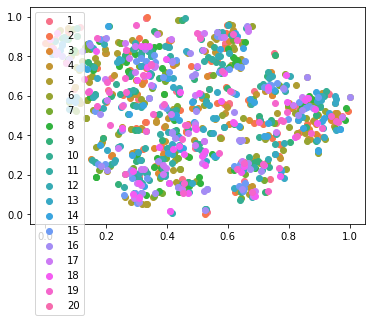

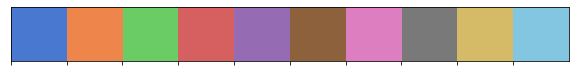

In [62]:
base_model = get_base_model(exp_name, contrastive, pre_fine_tuning, view_classification, dere)

train_dataset, test_dataset = get_ntuard('Data', num_clips=1, cross_subject=False, normal_mean=128, normal_std=128)
sampled_targets, itemize_index_by_target = get_sampled_targets(test_dataset, number_samples)

tsne, respective_targets, meta_data = get_tsne_representations(base_model, sampled_targets, test_dataset, get_bias, eval_mode=True)
get_visualizations(tsne, num_limited_targets, respective_targets)

Cluster 0


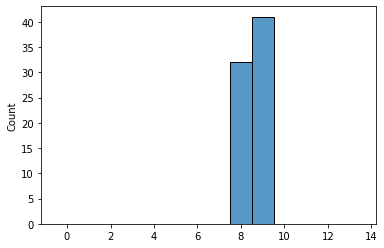

Cluster 1


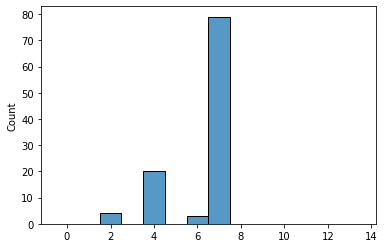

Cluster 2


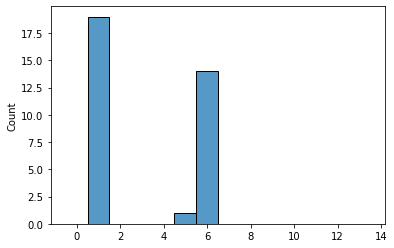

Cluster 3


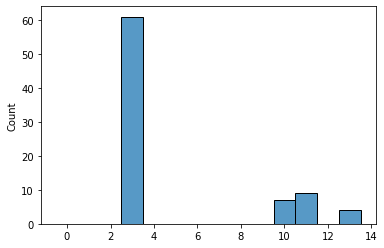

Cluster 4


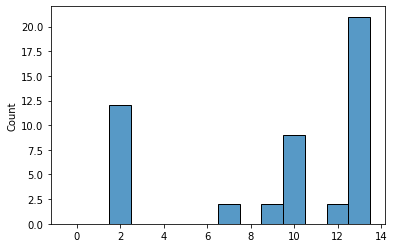

Cluster 5


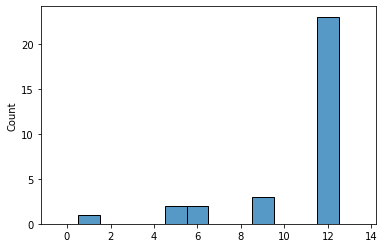

Cluster 6


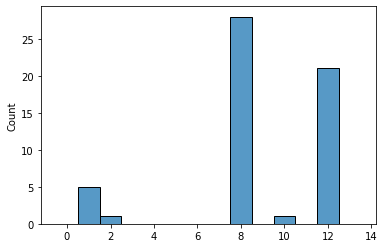

Cluster 7


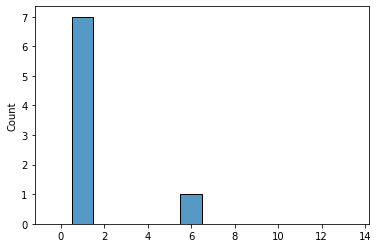

Cluster 8


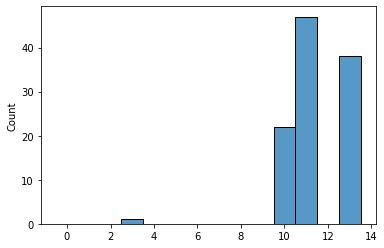

Cluster 9


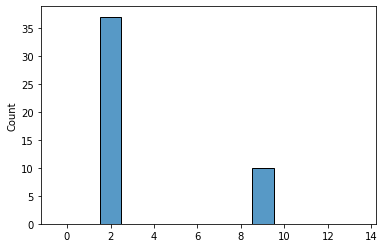

Cluster 10


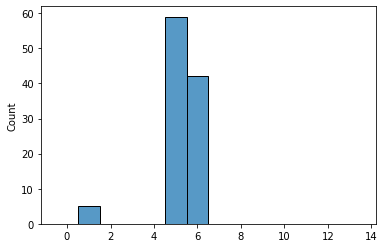

Cluster 11


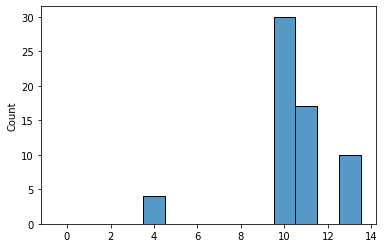

Cluster 12


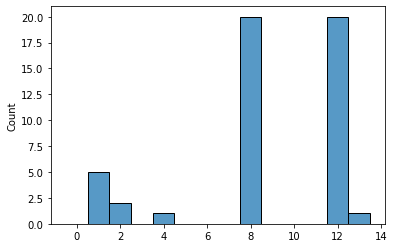

In [63]:
labels, indicies_per_cluster_label = get_clusters(tsne)
for cluster_label in indicies_per_cluster_label.keys():
    print("Cluster", cluster_label)
    sns.histplot([m.scene for i, m in \
                  enumerate(get_subset_arr(meta_data, cluster_label, \
                                           indicies_per_cluster_label))] , discrete=1, stat="count", binrange=(0,13))
    plt.show()


Cluster 0


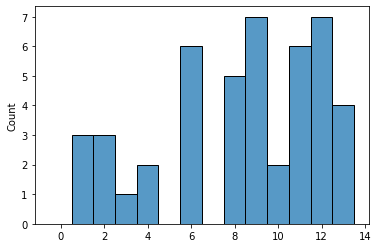

Cluster 1


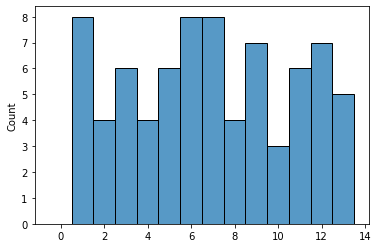

Cluster 2


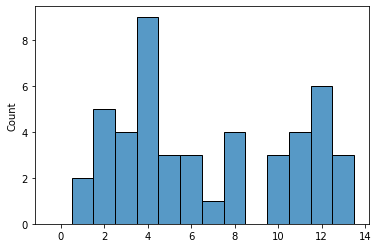

Cluster 3


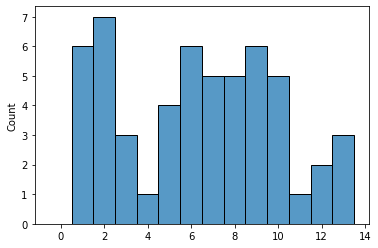

Cluster 4


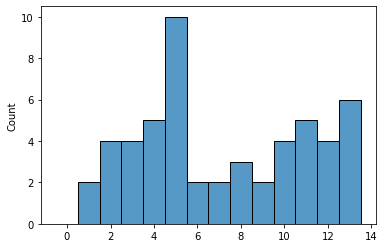

Cluster 5


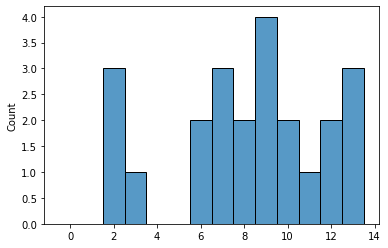

Cluster 6


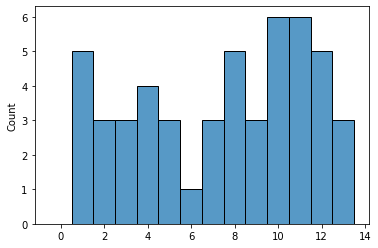

Cluster 7


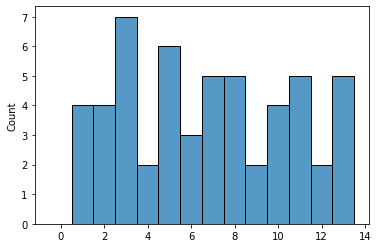

Cluster 8


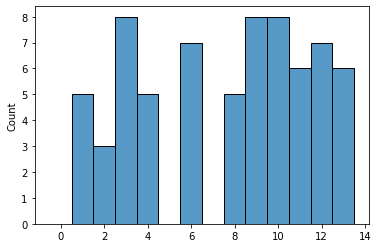

Cluster 9


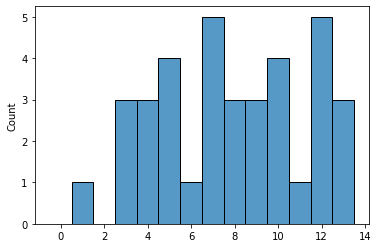

Cluster 10


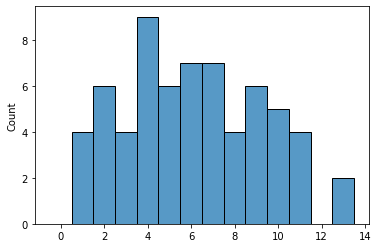

Cluster 11


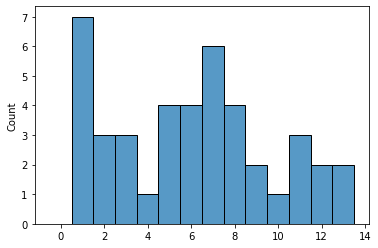

Cluster 12


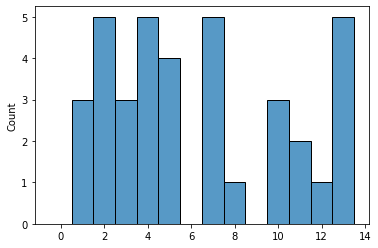

In [64]:
for cluster_label in indicies_per_cluster_label.keys():
    print("Cluster", cluster_label)
    sns.histplot([m.action for i, m in \
                  enumerate(get_subset_arr(meta_data, cluster_label, \
                                           indicies_per_cluster_label))] , discrete=1, stat="count", binrange=(0,13))
    plt.show()

Cluster 0


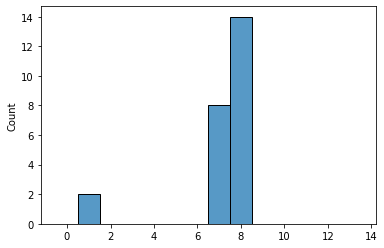

Cluster 1


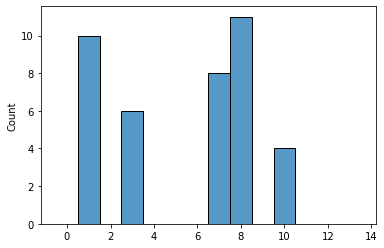

Cluster 2


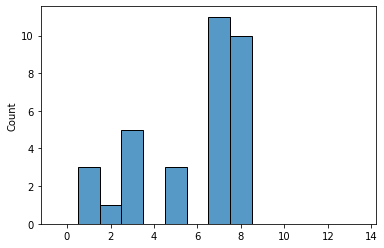

Cluster 3


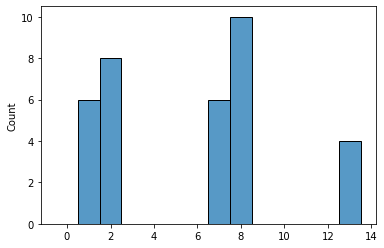

Cluster 4


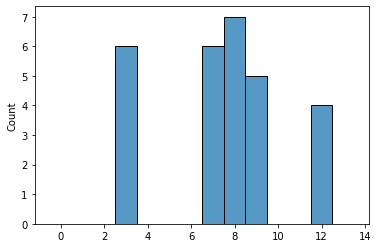

Cluster 5


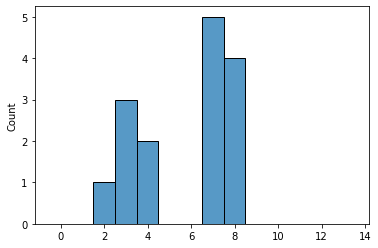

Cluster 6


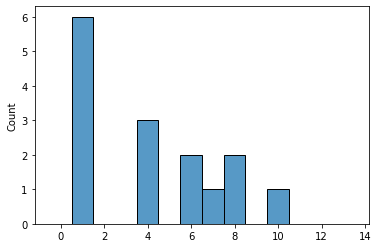

Cluster 7


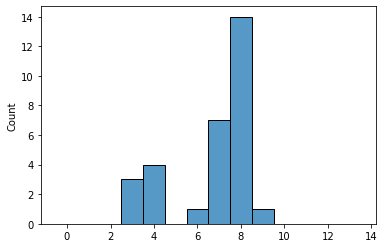

Cluster 8


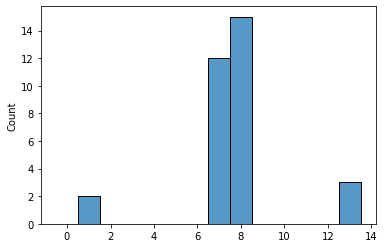

Cluster 9


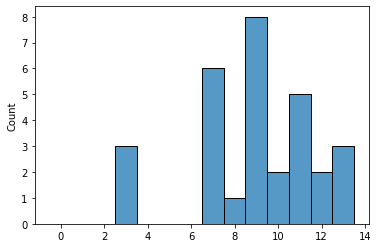

Cluster 10


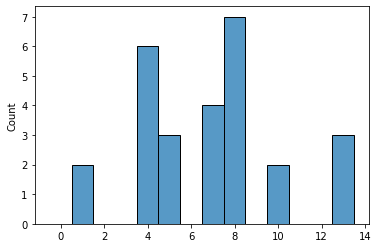

Cluster 11


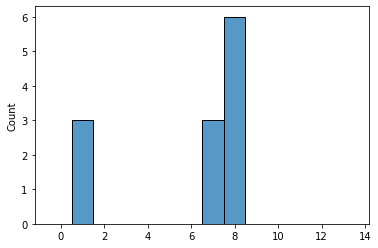

Cluster 12


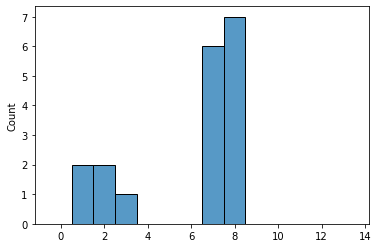

In [65]:
for cluster_label in indicies_per_cluster_label.keys():
    print("Cluster", cluster_label)
    sns.histplot([m.pid for i, m in \
                  enumerate(get_subset_arr(meta_data, cluster_label, \
                                           indicies_per_cluster_label))] , discrete=1, stat="count", binrange=(0,13))
    plt.show()

In [66]:
unique_scenes_dere_contrastive = get_unique_per_cluster(lambda cluster_label: [m.scene for i, m in \
                  enumerate(get_subset_arr(meta_data, cluster_label, \
                                           indicies_per_cluster_label))])
print("average unique_scenes_dere_contrastive", unique_scenes_dere_contrastive)
unique_actions_dere_contrastive = get_unique_per_cluster(lambda cluster_label: [m.action for i, m in \
                  enumerate(get_subset_arr(meta_data, cluster_label, \
                                           indicies_per_cluster_label))])
print("average unique_actions_dere_contrastive", unique_actions_dere_contrastive)
unique_persons_dere_contrastive = get_unique_per_cluster(lambda cluster_label: [m.pid for i, m in \
                  enumerate(get_subset_arr(meta_data, cluster_label, \
                                           indicies_per_cluster_label))])
print("average unique_pid_dere_contrastive", unique_persons_dere_contrastive)

average unique_scenes_dere_contrastive 5.076923076923077
average unique_actions_dere_contrastive 18.846153846153847
average unique_pid_dere_contrastive 14.0


# Analysis between View Invariant and Bias Representations

In [67]:
def get_bias_view_invariant_repr(base_model, sampled_targets, test_dataset):
    base_model.fc = None
    base_model.eval_mode = None
    base_model.cuda()
    contrastive_representations = []
    respective_targets = []
    meta_data = []
    bias_representations = []
    base_model.eval()
    for counter, i in enumerate(sampled_targets):
        data, target = test_dataset.__getitem__(i)
        other_metadata, view = test_dataset.video_paths[i]['path'].split("/")[-2:]
        scene, pid, rid, action = test_dataset._decrypt_vid_name(other_metadata)
        meta_data.append(NTUARD_MetaData(scene, action, pid, rid, int(view)))
        respective_targets.append(target)
        with torch.no_grad():
            base_model.eval_mode=True
            output = base_model(data.cuda())
            contrastive_repr, bias_repr = output
            contrastive_representations.append(contrastive_repr.squeeze().cpu().numpy())
            bias_representations.append(bias_repr.squeeze().cpu().numpy())
    contrastive_representations = np.array(contrastive_representations)
    bias_representations = np.array(bias_representations)

    return contrastive_representations, bias_representations, meta_data


In [68]:
### PARAMS ####
contrastive = True
pre_fine_tuning = True
view_classification = False
dere = True
exp_name = 'cross_view_dere_contrastive_resnet3D183264_False_clips_1_lr_0.002augmentFalse'
### PARAMS FOR VISUALIZATION ###
view_only_viz = False
number_samples = 50
num_limited_targets = 20

In [70]:
base_model = get_base_model(exp_name, contrastive, pre_fine_tuning, view_classification, dere)

train_dataset, test_dataset = get_ntuard('Data', num_clips=1, cross_subject=False)
sampled_targets, itemize_index_by_target = get_sampled_targets(test_dataset, number_samples)

output_representations, bias_representations, meta_data = get_bias_view_invariant_repr(base_model, sampled_targets, test_dataset)

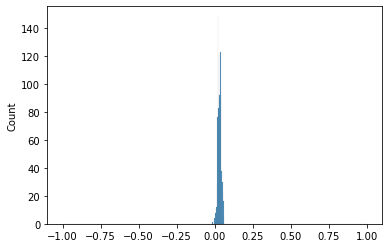

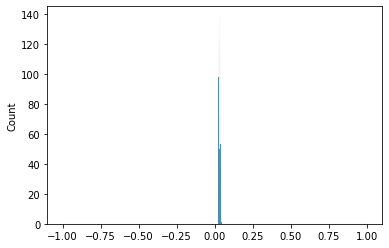

(1000,)

In [71]:
cos_sim = np.diagonal(np.inner(output_representations, bias_representations))/(np.linalg.norm(output_representations, axis=1)*np.linalg.norm(bias_representations, axis=1))
sns.histplot(cos_sim , discrete=0, stat="count", binrange=(-1,1))
plt.show()
cos_sim_first_row = np.inner(output_representations, bias_representations)[2]
cos_sim_norm_first_row = np.inner(np.linalg.norm(output_representations, axis=1).reshape(-1,1),np.linalg.norm(bias_representations, axis=1).reshape(-1,1))[2]

sns.histplot(cos_sim_first_row/cos_sim_norm_first_row , discrete=0, stat="count", binrange=(-1,1))
plt.show()
(cos_sim_first_row/cos_sim_norm_first_row).shape

In [21]:
np.inner(np.linalg.norm(output_representations, axis=1).reshape(-1,1),np.linalg.norm(bias_representations, axis=1).reshape(-1,1))[0]


(1000, 1000)

# Contrastive MultiClip Visualization and Breakdown Cluster Stats

These models were trained using three clips and the representations were the averaged result of three clips.

In [72]:
### PARAMS ####
contrastive = True
pre_fine_tuning = True
view_classification = False
dere = False
get_bias = False
exp_name = "cross_view_contrastive_same_timepoint_multiclipresnet3D183264_False_clips_3_lr_0.02augmentFalse"
#exp_name = 'cross_view_dere_contrastive_multiclip_resnet3D183264_False_clips_3_lr_0.002augmentFalse'
### PARAMS FOR VISUALIZATION ###
view_only_viz = False
number_samples = 50
num_limited_targets = 20
num_clips = 3
#compressed_repr, generated_output, contrastive_repr, view_classification


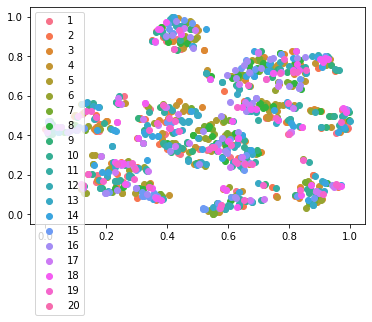

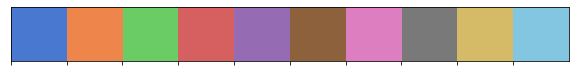

In [73]:
base_model = get_base_model(exp_name, contrastive, pre_fine_tuning, view_classification, dere)

train_dataset, test_dataset = get_ntuard('Data', num_clips=num_clips, cross_subject=False, normal_mean=128, normal_std=128)
sampled_targets, itemize_index_by_target = get_sampled_targets(test_dataset, number_samples)

tsne, respective_targets, meta_data = get_tsne_representations(base_model, sampled_targets, test_dataset, get_bias)
get_visualizations(tsne, num_limited_targets, respective_targets)

In [74]:
labels, indicies_per_cluster_label = get_clusters(tsne)

In [75]:
unique_scenes = get_unique_per_cluster(lambda cluster_label: [m.scene for i, m in \
                  enumerate(get_subset_arr(meta_data, cluster_label, \
                                           indicies_per_cluster_label))])
print("average unique_scenes", unique_scenes)
unique_actions = get_unique_per_cluster(lambda cluster_label: [m.action for i, m in \
                  enumerate(get_subset_arr(meta_data, cluster_label, \
                                           indicies_per_cluster_label))])
print("average unique_actions", unique_actions)
unique_persons = get_unique_per_cluster(lambda cluster_label: [m.pid for i, m in \
                  enumerate(get_subset_arr(meta_data, cluster_label, \
                                           indicies_per_cluster_label))])
print("average unique_pid", unique_persons)

average unique_scenes 3.0
average unique_actions 19.0
average unique_pid 13.153846153846153


Cluster 0


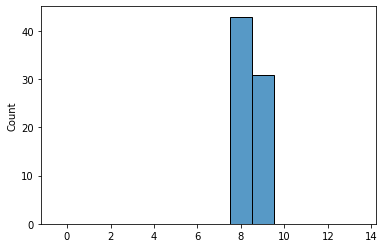

Cluster 1


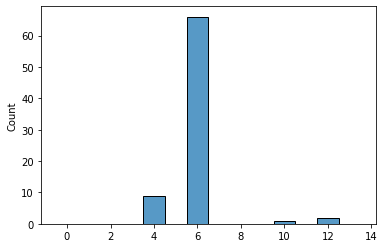

Cluster 2


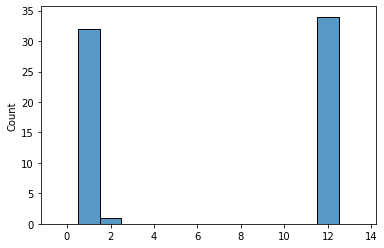

Cluster 3


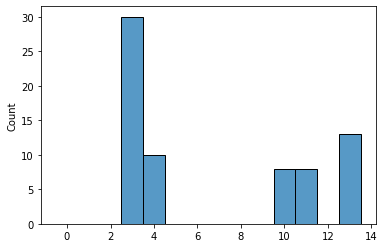

Cluster 4


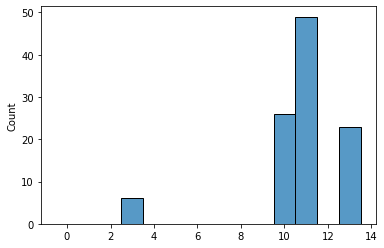

Cluster 5


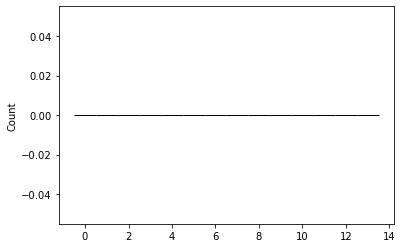

Cluster 6


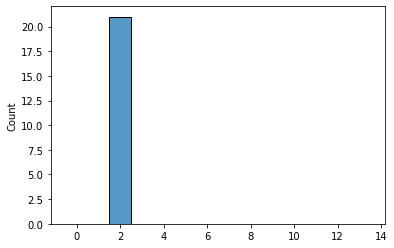

Cluster 7


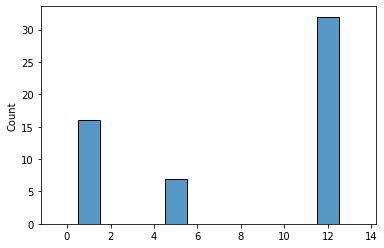

Cluster 8


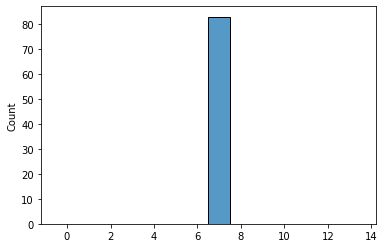

Cluster 9


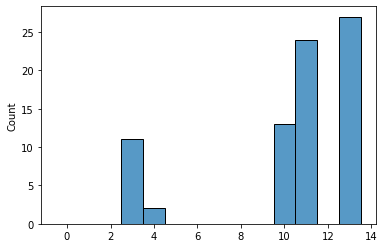

Cluster 10


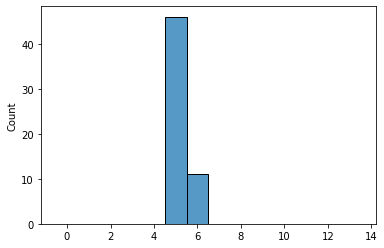

Cluster 11


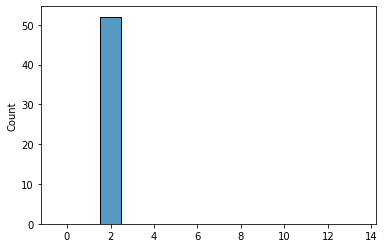

Cluster 12


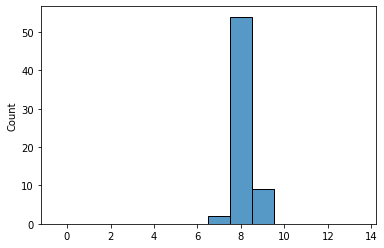

In [76]:
for cluster_label in indicies_per_cluster_label.keys():
    print("Cluster", cluster_label)
    sns.histplot([m.scene for i, m in \
                  enumerate(get_subset_arr(meta_data, cluster_label, \
                                           indicies_per_cluster_label))] , discrete=1, stat="count", binrange=(0,13))
    plt.show()


Cluster 0


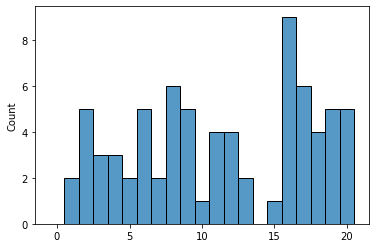

Cluster 1


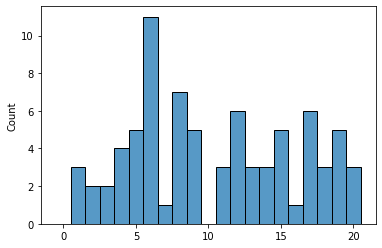

Cluster 2


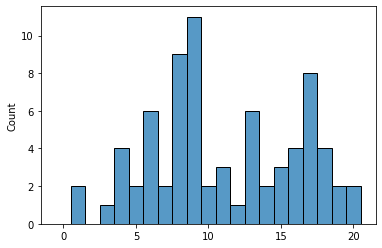

Cluster 3


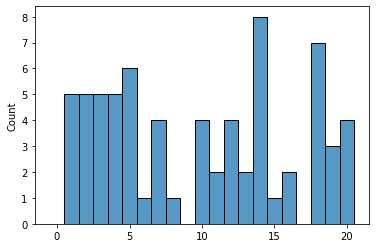

Cluster 4


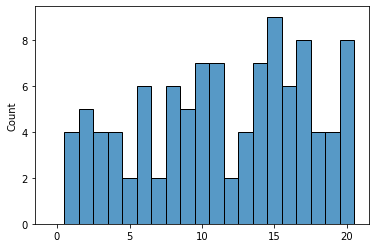

Cluster 5


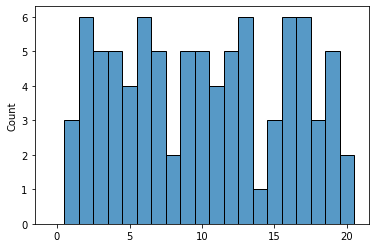

Cluster 6


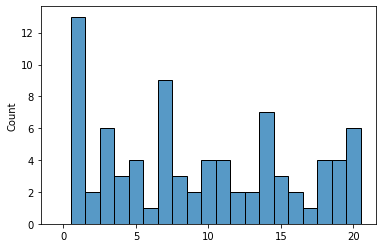

Cluster 7


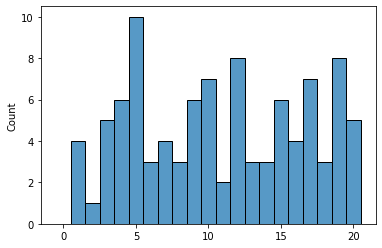

Cluster 8


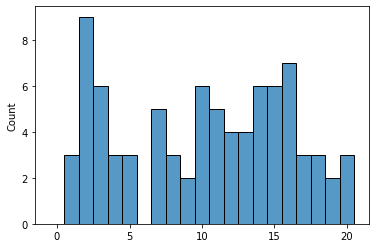

Cluster 9


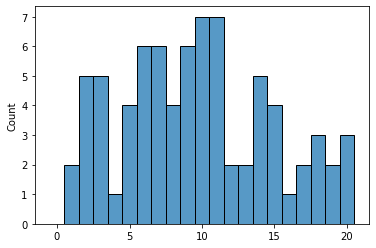

Cluster 10


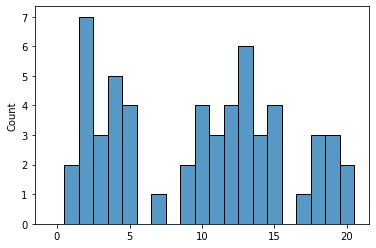

Cluster 11


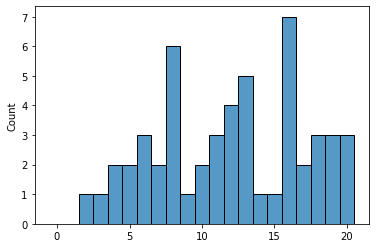

Cluster 12


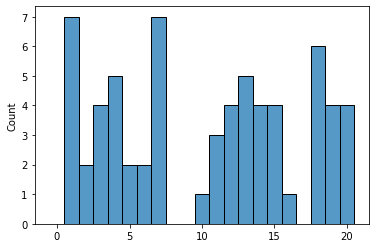

In [77]:
for cluster_label in indicies_per_cluster_label.keys():
    print("Cluster", cluster_label)
    sns.histplot([m.action for i, m in \
                  enumerate(get_subset_arr(meta_data, cluster_label, \
                                           indicies_per_cluster_label))] , discrete=1, stat="count", binrange=(0,20))
    plt.show()

Cluster 0


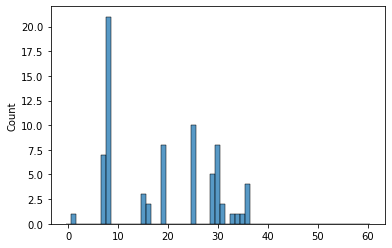

Cluster 1


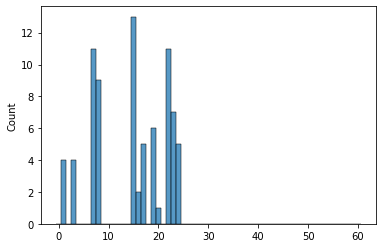

Cluster 2


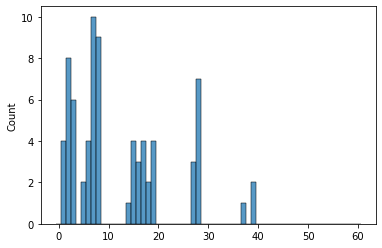

Cluster 3


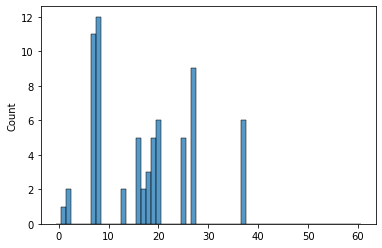

Cluster 4


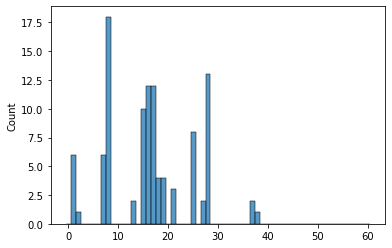

Cluster 5


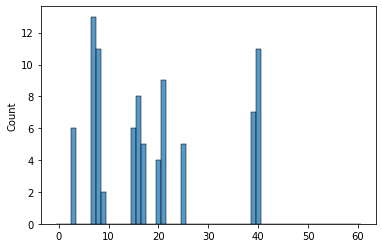

Cluster 6


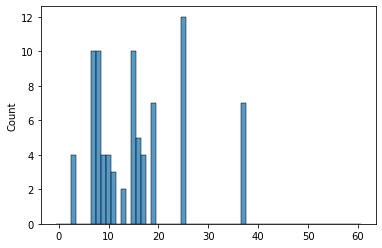

Cluster 7


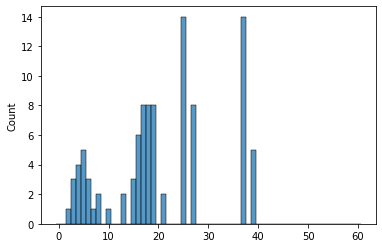

Cluster 8


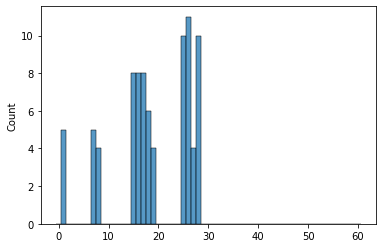

Cluster 9


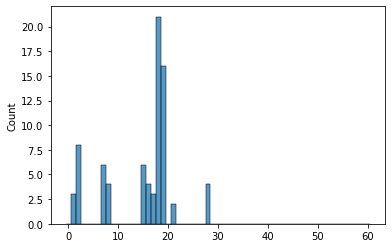

Cluster 10


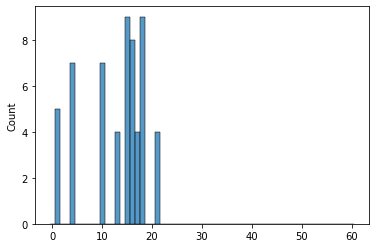

Cluster 11


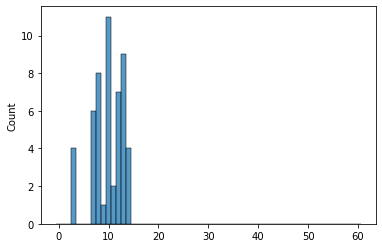

Cluster 12


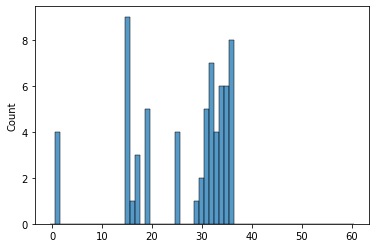

In [78]:
for cluster_label in indicies_per_cluster_label.keys():
    print("Cluster", cluster_label)
    sns.histplot([m.pid for i, m in \
                  enumerate(get_subset_arr(meta_data, cluster_label, \
                                           indicies_per_cluster_label))] , discrete=1, stat="count", binrange=(0,60))
    plt.show()

# DeRe Multiclip

In [37]:
### PARAMS ####
contrastive = True
pre_fine_tuning = True
view_classification = False
dere = True
get_bias = False
#exp_name = "cross_view_contrastive_same_timepoint_multiclipresnet3D183264_False_clips_3_lr_0.02augmentFalse"
exp_name = 'cross_view_dere_contrastive_multiclip_resnet3D183264_False_clips_3_lr_0.002augmentFalse'
### PARAMS FOR VISUALIZATION ###
view_only_viz = False
number_samples = 50
num_limited_targets = 20
num_clips = 3
#compressed_repr, generated_output, contrastive_repr, view_classification

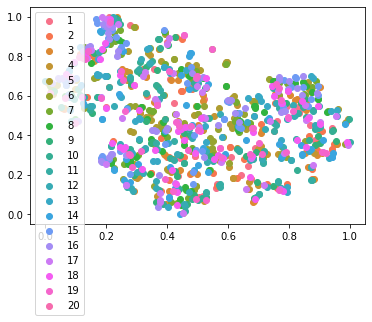

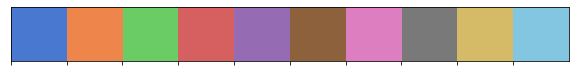

In [38]:
base_model = get_base_model(exp_name, contrastive, pre_fine_tuning, view_classification, dere)

train_dataset, test_dataset = get_ntuard('Data', num_clips=num_clips, cross_subject=False, normal_mean=128, normal_std=128)
sampled_targets, itemize_index_by_target = get_sampled_targets(test_dataset, number_samples)

tsne, respective_targets, meta_data = get_tsne_representations(base_model, sampled_targets, test_dataset, get_bias, eval_mode=True)
get_visualizations(tsne, num_limited_targets, respective_targets)

In [39]:
labels, indicies_per_cluster_label = get_clusters(tsne)

In [40]:
unique_scenes = get_unique_per_cluster(lambda cluster_label: [m.scene for i, m in \
                  enumerate(get_subset_arr(meta_data, cluster_label, \
                                           indicies_per_cluster_label))])
print("average unique_scenes", unique_scenes)
unique_actions = get_unique_per_cluster(lambda cluster_label: [m.action for i, m in \
                  enumerate(get_subset_arr(meta_data, cluster_label, \
                                           indicies_per_cluster_label))])
print("average unique_actions", unique_actions)
unique_persons = get_unique_per_cluster(lambda cluster_label: [m.pid for i, m in \
                  enumerate(get_subset_arr(meta_data, cluster_label, \
                                           indicies_per_cluster_label))])
print("average unique_pid", unique_persons)

average unique_scenes 5.6923076923076925
average unique_actions 18.692307692307693
average unique_pid 14.692307692307692


Cluster 0


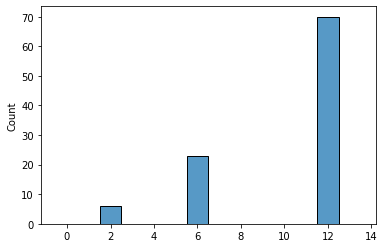

Cluster 1


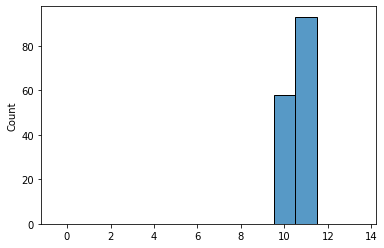

Cluster 2


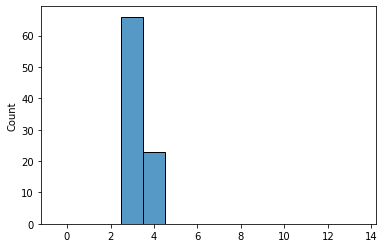

Cluster 3


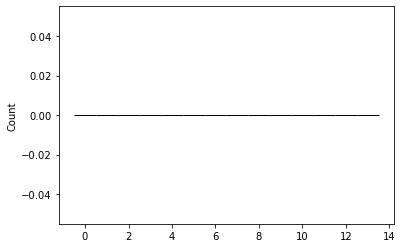

Cluster 4


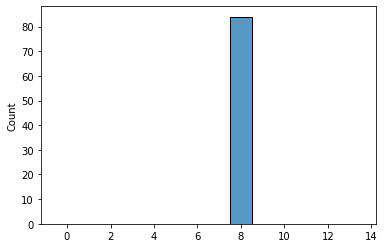

Cluster 5


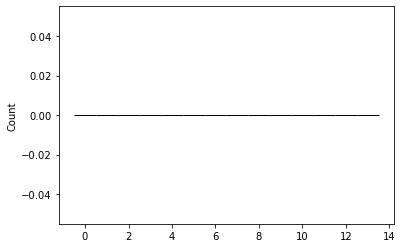

Cluster 6


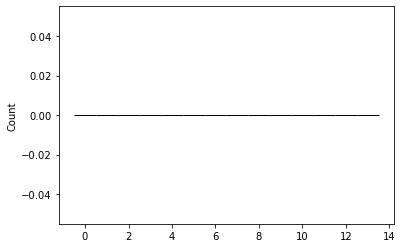

Cluster 7


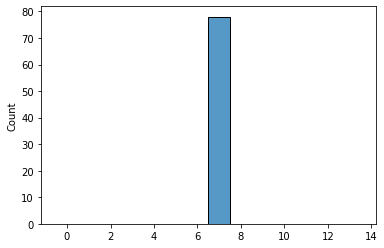

Cluster 8


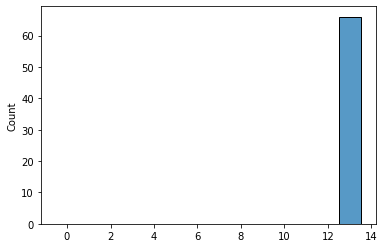

Cluster 9


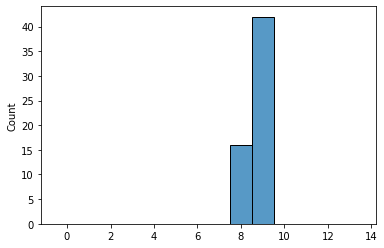

Cluster 10


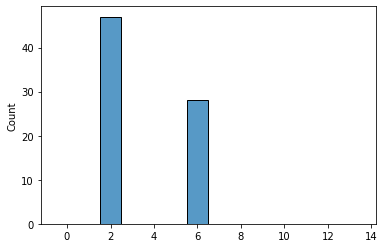

Cluster 11


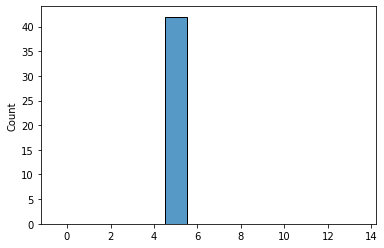

Cluster 12


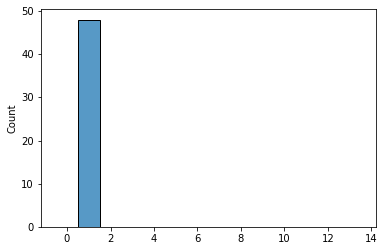

In [31]:
for cluster_label in indicies_per_cluster_label.keys():
    print("Cluster", cluster_label)
    sns.histplot([m.scene for i, m in \
                  enumerate(get_subset_arr(meta_data, cluster_label, \
                                           indicies_per_cluster_label))] , discrete=1, stat="count", binrange=(0,13))
    plt.show()


Cluster 0


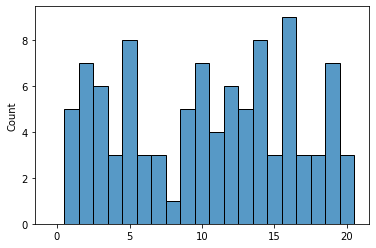

Cluster 1


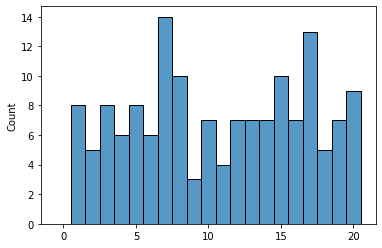

Cluster 2


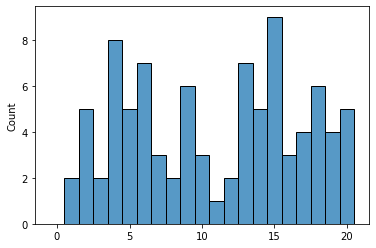

Cluster 3


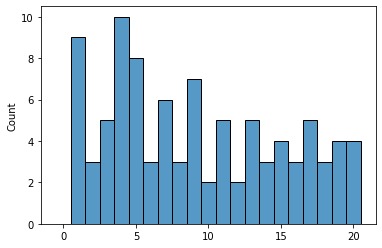

Cluster 4


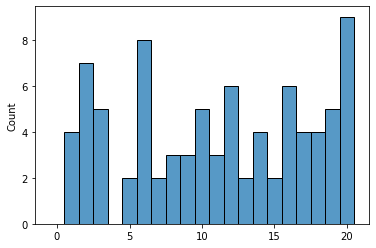

Cluster 5


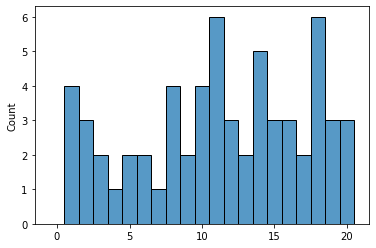

Cluster 6


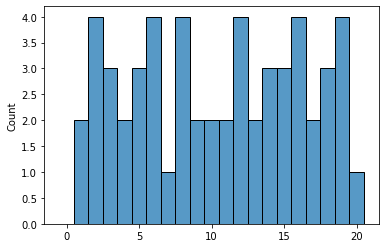

Cluster 7


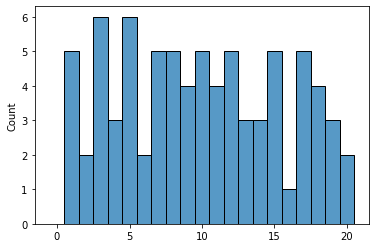

Cluster 8


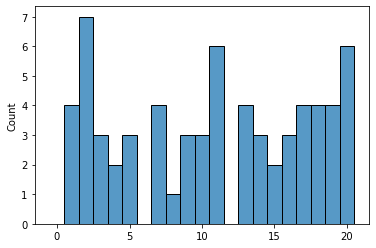

Cluster 9


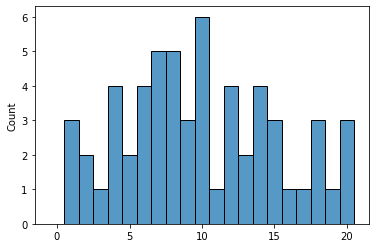

Cluster 10


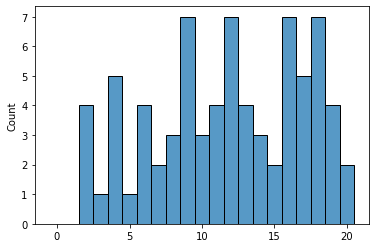

Cluster 11


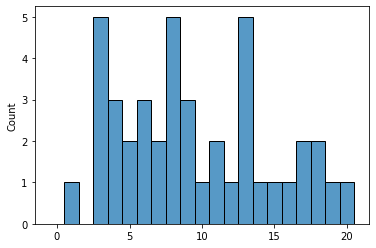

Cluster 12


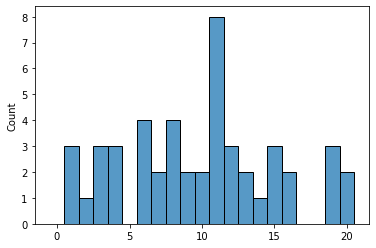

In [32]:
for cluster_label in indicies_per_cluster_label.keys():
    print("Cluster", cluster_label)
    sns.histplot([m.action for i, m in \
                  enumerate(get_subset_arr(meta_data, cluster_label, \
                                           indicies_per_cluster_label))] , discrete=1, stat="count", binrange=(0,20))
    plt.show()

Cluster 0


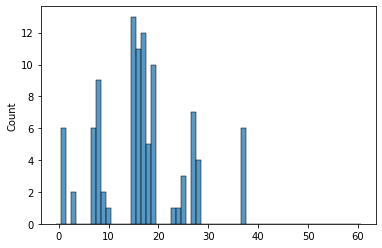

Cluster 1


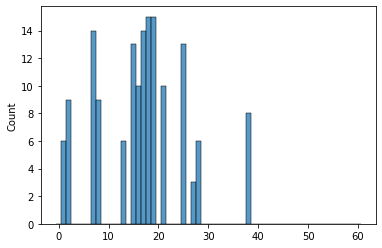

Cluster 2


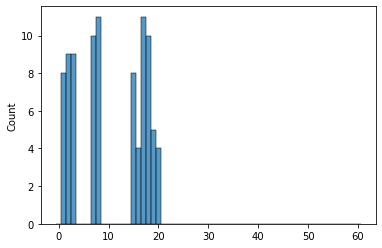

Cluster 3


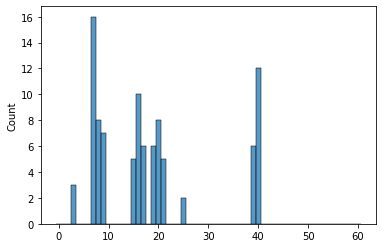

Cluster 4


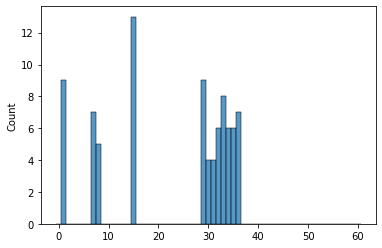

Cluster 5


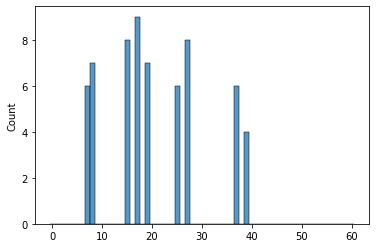

Cluster 6


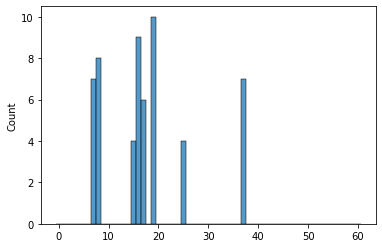

Cluster 7


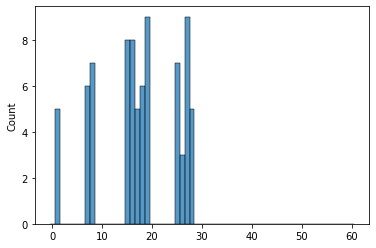

Cluster 8


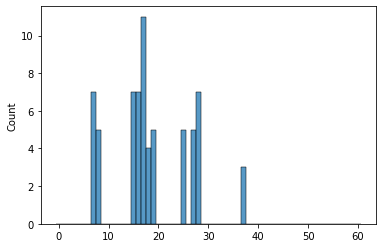

Cluster 9


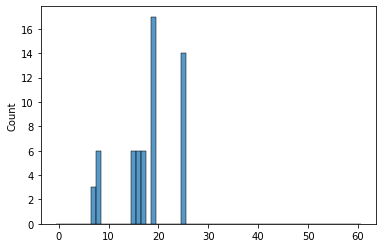

Cluster 10


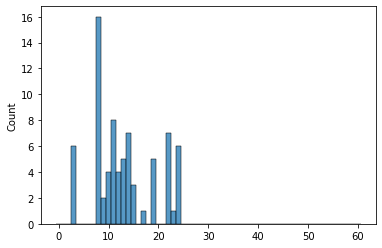

Cluster 11


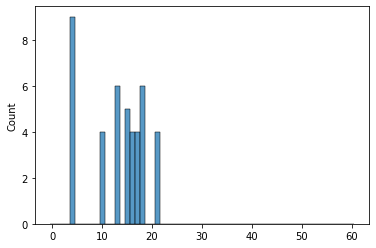

Cluster 12


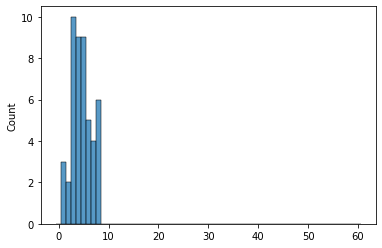

In [33]:
for cluster_label in indicies_per_cluster_label.keys():
    print("Cluster", cluster_label)
    sns.histplot([m.pid for i, m in \
                  enumerate(get_subset_arr(meta_data, cluster_label, \
                                           indicies_per_cluster_label))] , discrete=1, stat="count", binrange=(0,60))
    plt.show()

# Visualize Random Shuffle As Negative Example

In [20]:
### PARAMS ####
contrastive = True
pre_fine_tuning = True
view_classification = False
#exp_name = 'cv_same_timepoint_eval_single_clip_100contrastive_endpoint_A_finetune_TrueFalse'
exp_name = 'random_shuffle_negative_cross_viewresnet3D183264_False_clips_1_lr_2e-05augmentFalse'
#exp_name = 'preserve_first_last_shuffle_negative_cross_viewresnet3D183264_False_clips_1_lr_2e-05augmentFalse'
#exp_name = 'control_sup_con_cross_viewresnet3D183264_False_clips_1_lr_2e-05augmentFalse'
#exp_name = 'view_classificationresnet3D183264_False_clips_1_lr_0.002augmentFalse'
### PARAMS FOR VISUALIZATION ###
view_only_viz = False
number_samples = 50
num_limited_targets = 20
visualizations=False

#compressed_repr, generated_output, contrastive_repr, view_classification

In [21]:
base_model = get_base_model(exp_name, contrastive, pre_fine_tuning, visualizations=visualizations)

train_dataset, test_dataset = get_ntuard('Data', num_clips=1, cross_subject=False, normal_mean=128, normal_std=128)
sampled_targets, itemize_index_by_target = get_sampled_targets(test_dataset, number_samples)

tsne, respective_targets, meta_data = get_tsne_representations(base_model, sampled_targets, test_dataset)

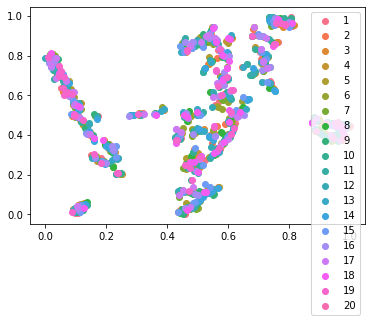

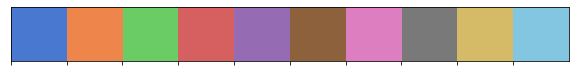

In [22]:
get_visualizations(tsne, num_limited_targets, respective_targets)

In [23]:
labels, indicies_per_cluster_label = get_clusters(tsne, k=13)
unique_scenes = get_unique_per_cluster(lambda cluster_label: [m.scene for i, m in \
                  enumerate(get_subset_arr(meta_data, cluster_label, \
                                           indicies_per_cluster_label))])
print("average unique_scenes", unique_scenes)
unique_actions = get_unique_per_cluster(lambda cluster_label: [m.action for i, m in \
                  enumerate(get_subset_arr(meta_data, cluster_label, \
                                           indicies_per_cluster_label))])
print("average unique_actions", unique_actions)
unique_persons = get_unique_per_cluster(lambda cluster_label: [m.pid for i, m in \
                  enumerate(get_subset_arr(meta_data, cluster_label, \
                                           indicies_per_cluster_label))])
print("average unique_pid", unique_persons)

average unique_scenes 4.538461538461538
average unique_actions 19.307692307692307
average unique_pid 12.615384615384615


Cluster 0


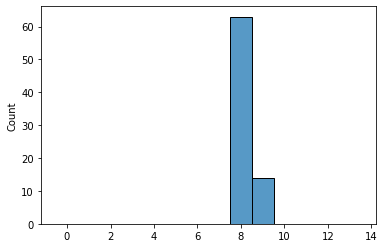

Cluster 1


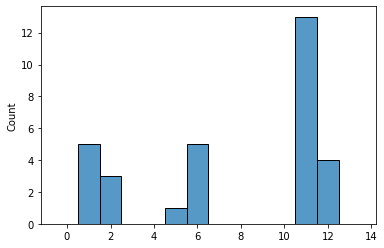

Cluster 2


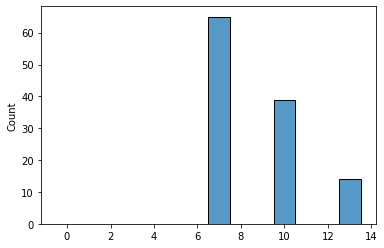

Cluster 3


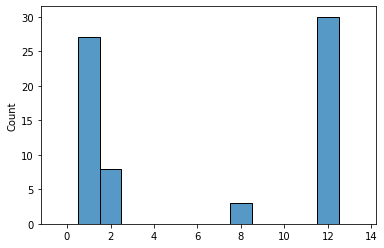

Cluster 4


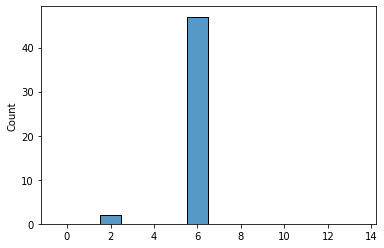

Cluster 5


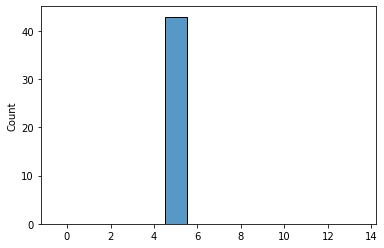

Cluster 6


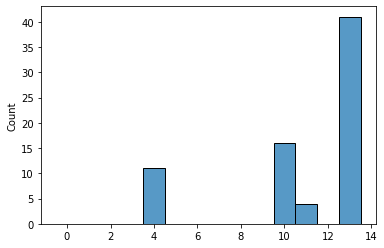

Cluster 7


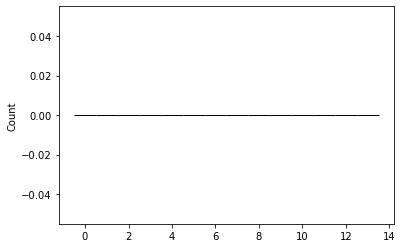

Cluster 8


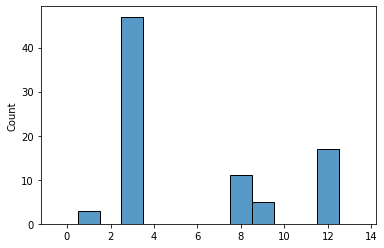

Cluster 9


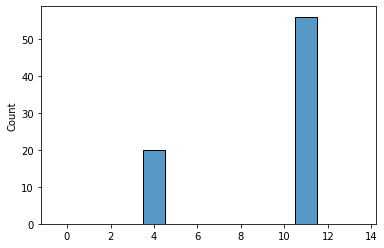

Cluster 10


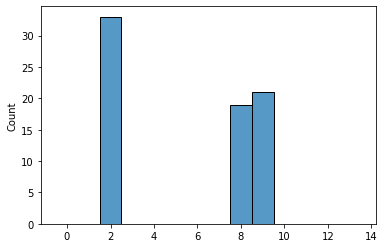

Cluster 11


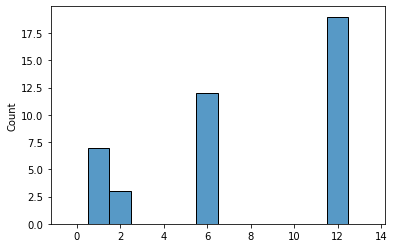

Cluster 12


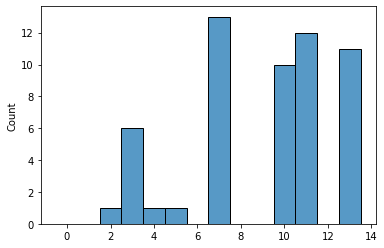

In [24]:
for cluster_label in indicies_per_cluster_label.keys():
    print("Cluster", cluster_label)
    sns.histplot([m.scene for i, m in \
                  enumerate(get_subset_arr(meta_data, cluster_label, \
                                           indicies_per_cluster_label))] , discrete=1, stat="count", binrange=(0,13))
    plt.show()


Cluster 0


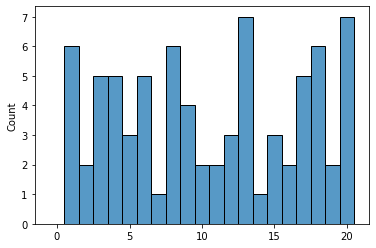

Cluster 1


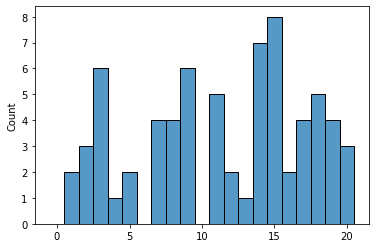

Cluster 2


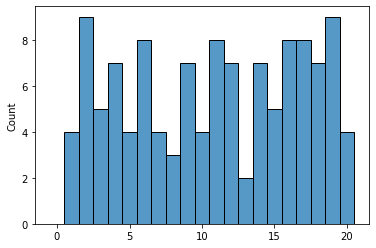

Cluster 3


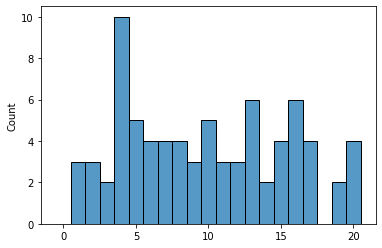

Cluster 4


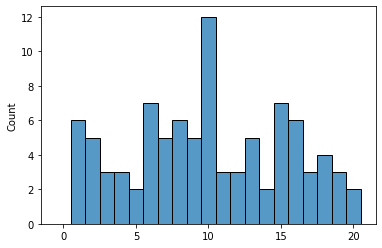

Cluster 5


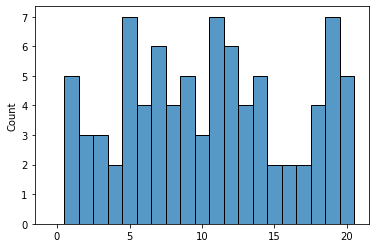

Cluster 6


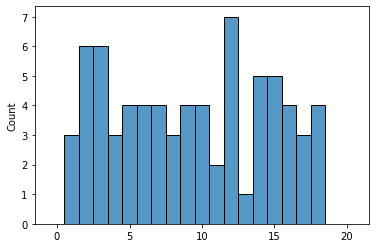

Cluster 7


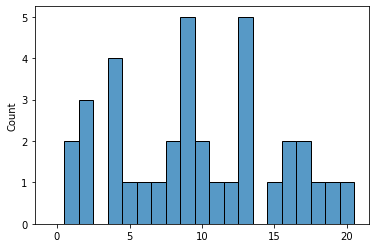

Cluster 8


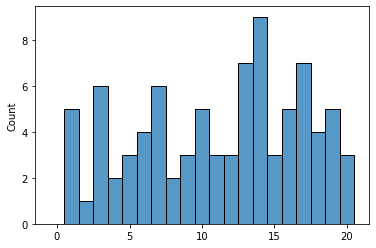

Cluster 9


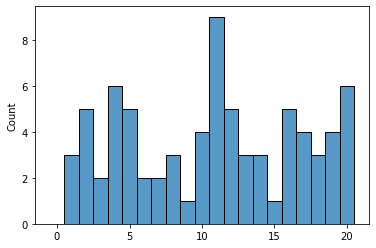

Cluster 10


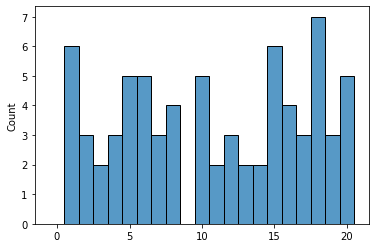

Cluster 11


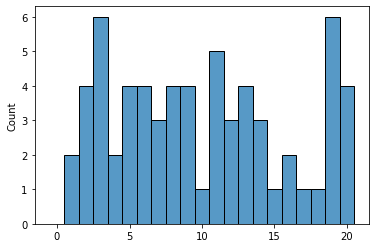

Cluster 12


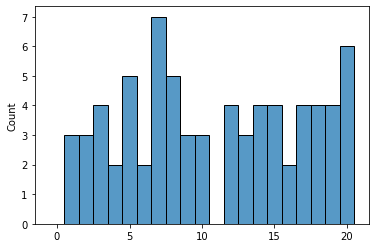

In [25]:
for cluster_label in indicies_per_cluster_label.keys():
    print("Cluster", cluster_label)
    sns.histplot([m.action for i, m in \
                  enumerate(get_subset_arr(meta_data, cluster_label, \
                                           indicies_per_cluster_label))] , discrete=1, stat="count", binrange=(0,20))
    plt.show()

Cluster 0


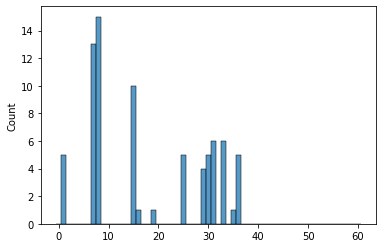

Cluster 1


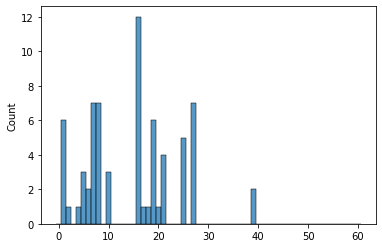

Cluster 2


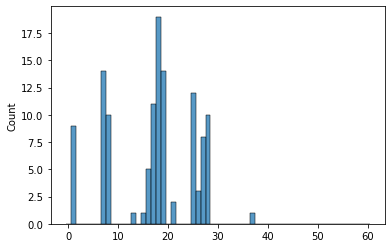

Cluster 3


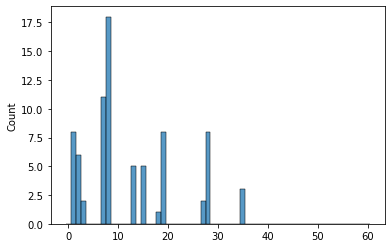

Cluster 4


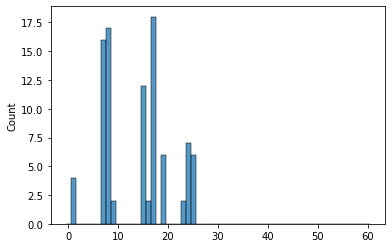

Cluster 5


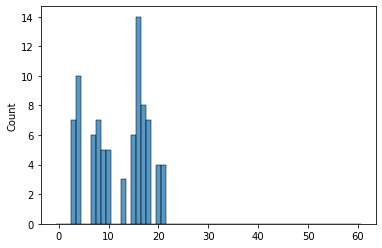

Cluster 6


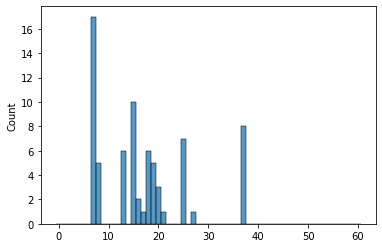

Cluster 7


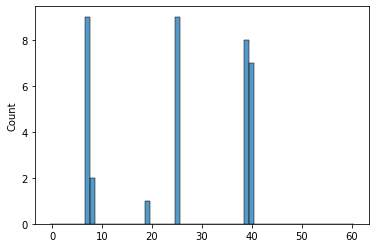

Cluster 8


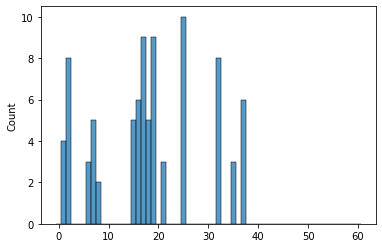

Cluster 9


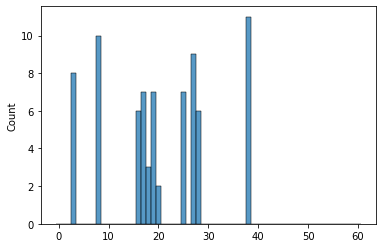

Cluster 10


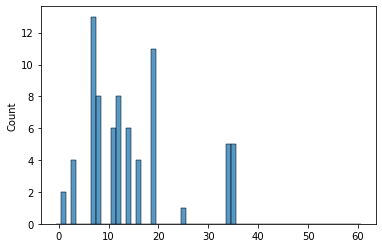

Cluster 11


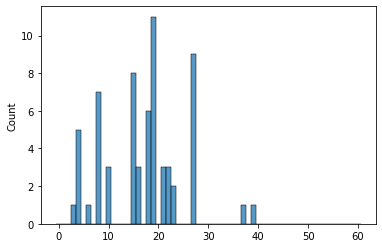

Cluster 12


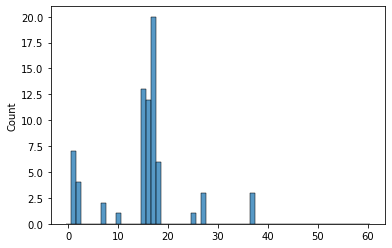

In [26]:
for cluster_label in indicies_per_cluster_label.keys():
    print("Cluster", cluster_label)
    sns.histplot([m.pid for i, m in \
                  enumerate(get_subset_arr(meta_data, cluster_label, \
                                           indicies_per_cluster_label))] , discrete=1, stat="count", binrange=(0,60))
    plt.show()

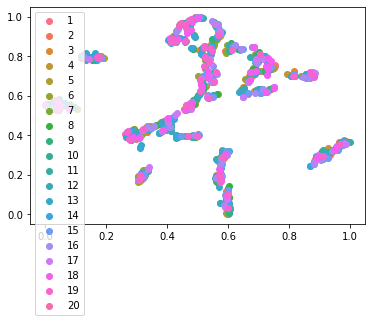

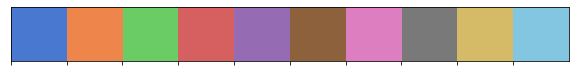

In [27]:
### PARAMS ####
contrastive = True
pre_fine_tuning = True
view_classification = False
#exp_name = 'cv_same_timepoint_eval_single_clip_100contrastive_endpoint_A_finetune_TrueFalse'
#exp_name = 'random_shuffle_negative_cross_viewresnet3D183264_False_clips_1_lr_2e-05augmentFalse'
exp_name = 'preserve_first_last_shuffle_negative_cross_viewresnet3D183264_False_clips_1_lr_2e-05augmentFalse'
#exp_name = 'control_sup_con_cross_viewresnet3D183264_False_clips_1_lr_2e-05augmentFalse'
#exp_name = 'view_classificationresnet3D183264_False_clips_1_lr_0.002augmentFalse'
### PARAMS FOR VISUALIZATION ###
view_only_viz = False
number_samples = 50
num_limited_targets = 20
visualizations=False

#compressed_repr, generated_output, contrastive_repr, view_classification

base_model = get_base_model(exp_name, contrastive, pre_fine_tuning, visualizations=visualizations)

train_dataset, test_dataset = get_ntuard('Data', num_clips=1, cross_subject=False, normal_mean=128, normal_std=128)
sampled_targets, itemize_index_by_target = get_sampled_targets(test_dataset, number_samples)

tsne, respective_targets, meta_data = get_tsne_representations(base_model, sampled_targets, test_dataset)
get_visualizations(tsne, num_limited_targets, respective_targets)

In [28]:
labels, indicies_per_cluster_label = get_clusters(tsne, k=13)
unique_scenes = get_unique_per_cluster(lambda cluster_label: [m.scene for i, m in \
                  enumerate(get_subset_arr(meta_data, cluster_label, \
                                           indicies_per_cluster_label))])
print("average unique_scenes", unique_scenes)
unique_actions = get_unique_per_cluster(lambda cluster_label: [m.action for i, m in \
                  enumerate(get_subset_arr(meta_data, cluster_label, \
                                           indicies_per_cluster_label))])
print("average unique_actions", unique_actions)
unique_persons = get_unique_per_cluster(lambda cluster_label: [m.pid for i, m in \
                  enumerate(get_subset_arr(meta_data, cluster_label, \
                                           indicies_per_cluster_label))])
print("average unique_pid", unique_persons)

average unique_scenes 3.1538461538461537
average unique_actions 19.307692307692307
average unique_pid 11.846153846153847


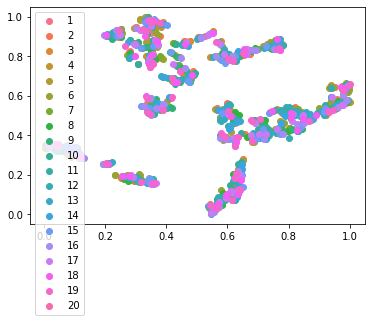

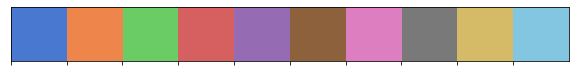

In [34]:
### PARAMS ####
contrastive = True
pre_fine_tuning = True
view_classification = False
#exp_name = 'cv_same_timepoint_eval_single_clip_100contrastive_endpoint_A_finetune_TrueFalse'
#exp_name = 'random_shuffle_negative_cross_viewresnet3D183264_False_clips_1_lr_2e-05augmentFalse'
#exp_name = 'preserve_first_last_shuffle_negative_cross_viewresnet3D183264_False_clips_1_lr_2e-05augmentFalse'
exp_name = 'control_sup_con_cross_viewresnet3D183264_False_clips_1_lr_2e-05augmentFalse'
#exp_name = 'view_classificationresnet3D183264_False_clips_1_lr_0.002augmentFalse'
### PARAMS FOR VISUALIZATION ###
view_only_viz = False
number_samples = 50
num_limited_targets = 20
visualizations=False

#compressed_repr, generated_output, contrastive_repr, view_classification

base_model = get_base_model(exp_name, contrastive, pre_fine_tuning, visualizations=visualizations)

train_dataset, test_dataset = get_ntuard('Data', num_clips=1, cross_subject=False, normal_mean=128, normal_std=128)
sampled_targets, itemize_index_by_target = get_sampled_targets(test_dataset, number_samples)

tsne, respective_targets, meta_data = get_tsne_representations(base_model, sampled_targets, test_dataset)
get_visualizations(tsne, num_limited_targets, respective_targets)

In [36]:
labels, indicies_per_cluster_label = get_clusters(tsne, k=13)
unique_scenes = get_unique_per_cluster(lambda cluster_label: [m.scene for i, m in \
                  enumerate(get_subset_arr(meta_data, cluster_label, \
                                           indicies_per_cluster_label))])
print("average unique_scenes", unique_scenes)
unique_actions = get_unique_per_cluster(lambda cluster_label: [m.action for i, m in \
                  enumerate(get_subset_arr(meta_data, cluster_label, \
                                           indicies_per_cluster_label))])
print("average unique_actions", unique_actions)
unique_persons = get_unique_per_cluster(lambda cluster_label: [m.pid for i, m in \
                  enumerate(get_subset_arr(meta_data, cluster_label, \
                                           indicies_per_cluster_label))])
print("average unique_pid", unique_persons)

average unique_scenes 4.384615384615385
average unique_actions 19.384615384615383
average unique_pid 12.23076923076923


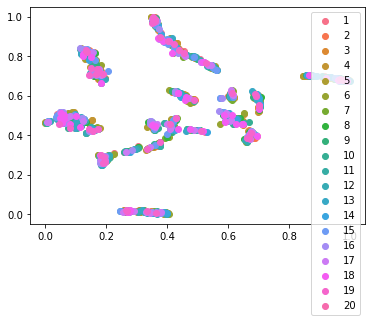

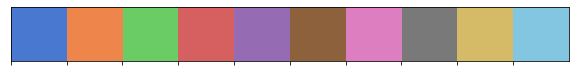

In [31]:
### PARAMS ####
contrastive = True
pre_fine_tuning = True
view_classification = False
#exp_name = 'cv_same_timepoint_eval_single_clip_100contrastive_endpoint_A_finetune_TrueFalse'
#exp_name = 'random_shuffle_negative_cross_viewresnet3D183264_False_clips_1_lr_2e-05augmentFalse'
#exp_name = 'preserve_first_last_shuffle_negative_cross_viewresnet3D183264_False_clips_1_lr_2e-05augmentFalse'
exp_name='preserve_first2_last2_shuffle_negative_cross_viewresnet3D183264_False_clips_1_lr_2e-05augmentFalse'
#exp_name = 'view_classificationresnet3D183264_False_clips_1_lr_0.002augmentFalse'
### PARAMS FOR VISUALIZATION ###
view_only_viz = False
number_samples = 50
num_limited_targets = 20
visualizations=False

#compressed_repr, generated_output, contrastive_repr, view_classification

base_model = get_base_model(exp_name, contrastive, pre_fine_tuning, visualizations=visualizations)

train_dataset, test_dataset = get_ntuard('Data', num_clips=1, cross_subject=False, normal_mean=128, normal_std=128)
sampled_targets, itemize_index_by_target = get_sampled_targets(test_dataset, number_samples)

tsne, respective_targets, meta_data = get_tsne_representations(base_model, sampled_targets, test_dataset)
get_visualizations(tsne, num_limited_targets, respective_targets)

In [32]:
labels, indicies_per_cluster_label = get_clusters(tsne, k=13)
unique_scenes = get_unique_per_cluster(lambda cluster_label: [m.scene for i, m in \
                  enumerate(get_subset_arr(meta_data, cluster_label, \
                                           indicies_per_cluster_label))])
print("average unique_scenes", unique_scenes)
unique_actions = get_unique_per_cluster(lambda cluster_label: [m.action for i, m in \
                  enumerate(get_subset_arr(meta_data, cluster_label, \
                                           indicies_per_cluster_label))])
print("average unique_actions", unique_actions)
unique_persons = get_unique_per_cluster(lambda cluster_label: [m.pid for i, m in \
                  enumerate(get_subset_arr(meta_data, cluster_label, \
                                           indicies_per_cluster_label))])
print("average unique_pid", unique_persons)

average unique_scenes 3.1538461538461537
average unique_actions 19.384615384615383
average unique_pid 11.76923076923077


# Grad Cam

In [11]:
!pip install grad-cam
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
!pip install ttach

In [3]:
import mediapy as media
import einops
def show_video(data, normalization_counter_factor=128):
    data = einops.rearrange(data, 'b c f h w -> (b f) h w c')
    
    output_video = ((data.detach().numpy()*normalization_counter_factor)+normalization_counter_factor).astype(np.uint8)
    print(output_video.shape)
    media.show_video(output_video.squeeze(),codec='gif', fps=2) 

In [4]:
def visualize_grad_cam(data, heatmap):
    # one off alignment (skip last frame, or copy)
    chosen_channel = 0
    i_num, x_num, y_num = heatmap.shape
    for i in range(i_num):
        for x in range(x_num):
            for y in range(y_num):
                data[i, x, y, chosen_channel] = heatmap[i, x, y]
    return data

55.37447257383966
Predicted tensor(12, device='cuda:0')
1 tensor(12, device='cuda:0')
Predicted tensor(1, device='cuda:0')
(8, 112, 112, 3)


<ipython-input-5-9a7de5e245b8>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prediction = torch.argmax(F.softmax(base_model(data.cuda()).squeeze())) + 1



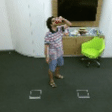

torch.Size([60])


IndexError: too many indices for tensor of dimension 1

In [5]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
from torchvision.models.video import r3d_18
import numpy as np
import einops
import torch.nn.functional as F

number_samples = 10
num_limited_targets=10
### PARAMS ####
contrastive = True
pre_fine_tuning = False
view_classification = False
exp_name = 'cv_same_timepoint_eval_single_clip_100contrastive_endpoint_A_finetune_TrueFalse'
#exp_name = 'cross_view_contrastive_same_timepointresnet3D1832128_False_clips_1_lr_0.02augmentFalse'
#exp_name = 'supervised_CV_10resnet3D181616_False_clips_1_gru_False_CS_False'
#exp_name = 'view_classificationresnet3D183264_False_clips_1_lr_0.002augmentFalse'
### PARAMS FOR VISUALIZATION ###
view_only_viz = False
base_model = get_base_model(exp_name, contrastive, pre_fine_tuning, visualizations=True)
base_model.cuda()
base_model.eval_mode=True
#compressed_repr, generated_output, contrastive_repr, view_classification
_, viz_test_dataset = get_ntuard('Data', num_clips=1, cross_subject=False, norm=True, )
sampled_targets, itemize_index_by_target = get_sampled_targets(viz_test_dataset, number_samples, num_limited_targets)
for target_viz in range(1,num_limited_targets):
    num_incorrect = 0
    for idx in range(len(itemize_index_by_target[target_viz])):
        if itemize_index_by_target[target_viz][idx] not in sampled_targets:
            continue
        i = itemize_index_by_target[target_viz][idx]
        data, target = viz_test_dataset.__getitem__(i)

        base_model.eval()
        prediction = torch.argmax(F.softmax(base_model(data.cuda()).squeeze())) + 1
        print("Predicted", prediction)

        if target_viz == prediction.item():

            show_video(data, normalization_counter_factor=0.5)

            input_tensor, _ = viz_test_dataset.__getitem__(i)
            input_tensor = einops.rearrange(input_tensor, 'b c f h w -> b c f h w')
            # Create an input tensor image for your model..
            # Note: input_tensor can be a batch tensor with several images!

            # Construct the CAM object once, and then re-use it on many images:
            if contrastive:
                target_layer = base_model.base_model.layer4
            else:
                target_layer = base_model.layer4
            print(base_model(input_tensor.cuda()).shape)

            cam = GradCAM(model=base_model, target_layer=target_layer, use_cuda=True) 

            # If target_category is None, the highest scoring category
            # will be used for every image in the batch.
            # target_category can also be an integer, or a list of different integers
            # for every image in the batch.
            target_category = target_viz
            # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
            grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)

            # In this example grayscale_cam has only one image in the batch:
            #grayscale_cam = grayscale_cam[0, :]
            #visualization = show_cam_on_image(data, grayscale_cam)


            grayscale_cam=(grayscale_cam*255).astype(np.uint8).reshape(112,112,7)
            grayscale_cam = einops.rearrange(grayscale_cam, 'h w f -> f h w')
            media.show_video(grayscale_cam, fps=2) 
            media.show_video(visualize_grad_cam(data, grayscale_cam), fps=2)
            continue
        else:
            print(target_viz, prediction)
            num_incorrect+=1
    print("Percent incorrect, ", num_incorrect/len(itemize_index_by_target[target_viz]))
    

In [40]:
base_model.eval_mode = True
input_tensor, _ = viz_test_dataset.__getitem__(i)
print(input_tensor.shape)
output_video = base_model(input_tensor).detach().numpy()
output_video = (output_video*255).astype(np.uint8)
print(output_video.shape)
media.show_video(output_video.squeeze(), fps=2) 


torch.Size([1, 3, 8, 112, 112])


AttributeError: 'tuple' object has no attribute 'detach'

In [48]:
print(base_model(input_tensor.cuda()).shape)

torch.Size([1, 1, 60])


# Visualize Decoder Output

13.095991561181435
Original input:
(8, 112, 112, 3)



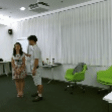

Reconstructed output dere with contrastive:
(8, 112, 112, 3)



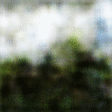

Reconstructed output dere with only bias repr contrastive:
(8, 112, 112, 3)



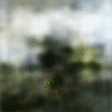

Reconstructed output dere with only invariant repr contrastive:
(8, 112, 112, 3)



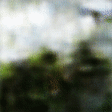

Reconstructed output dere without contrastive:
(8, 112, 112, 3)



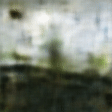

Original input:
(8, 112, 112, 3)



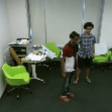

Reconstructed output dere with contrastive:
(8, 112, 112, 3)



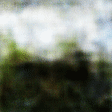

Reconstructed output dere with only bias repr contrastive:
(8, 112, 112, 3)



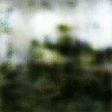

Reconstructed output dere with only invariant repr contrastive:
(8, 112, 112, 3)



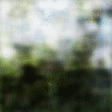

Reconstructed output dere without contrastive:
(8, 112, 112, 3)



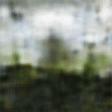

Original input:
(8, 112, 112, 3)



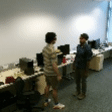

Reconstructed output dere with contrastive:
(8, 112, 112, 3)



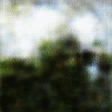

Reconstructed output dere with only bias repr contrastive:
(8, 112, 112, 3)



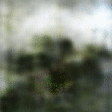

Reconstructed output dere with only invariant repr contrastive:
(8, 112, 112, 3)



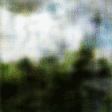

Reconstructed output dere without contrastive:
(8, 112, 112, 3)



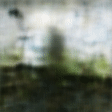

Original input:
(8, 112, 112, 3)



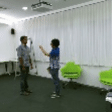

Reconstructed output dere with contrastive:
(8, 112, 112, 3)



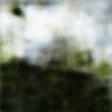

Reconstructed output dere with only bias repr contrastive:
(8, 112, 112, 3)



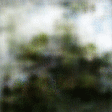

Reconstructed output dere with only invariant repr contrastive:
(8, 112, 112, 3)



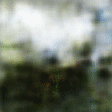

Reconstructed output dere without contrastive:
(8, 112, 112, 3)



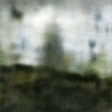

Original input:
(8, 112, 112, 3)



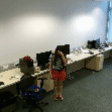

Reconstructed output dere with contrastive:
(8, 112, 112, 3)



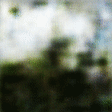

Reconstructed output dere with only bias repr contrastive:


In [ ]:
### PARAMS ####
contrastive = True
pre_fine_tuning = True
view_classification = False
dere = True
get_bias = False
#exp_name = 'cv_same_timepoint_eval_single_clip_100contrastive_endpoint_A_finetune_TrueFalse'
#exp_name = 'cross_view_contrastive_same_timepointresnet3D1832128_False_clips_1_lr_0.02augmentFalse'
#exp_name = 'supervised_CV_10resnet3D181616_False_clips_1_gru_False_CS_False'
exp_name = 'cross_view_dere_contrastive_resnet3D183264_False_clips_1_lr_0.002augmentFalse'
exp_name2 = 'dere_without_contrastive_10contrastive_endpoint_A_finetune_FalseFalse'

### PARAMS FOR VISUALIZATION ###
view_only_viz = False
number_samples = 2
num_limited_targets = 5
target_viz=1
base_model = get_base_model(exp_name, contrastive, pre_fine_tuning, view_classification, dere)
base_model2 = get_base_model(exp_name2, False, pre_fine_tuning, view_classification, dere)


train_dataset, test_dataset = get_ntuard('Data', num_clips=1, cross_subject=False, norm=True, normal_mean=128, normal_std=128, num_frames=8)
sampled_targets, itemize_index_by_target = get_sampled_targets(test_dataset, number_samples, num_limited_targets)
#compressed_repr, generated_output, contrastive_repr, view_classification

def get_output_from_dere(base_model, data, contrastive_head=False, bias_only=True, invariant_only=True):
    x = base_model.encoder(data)
    repr_size = x.shape[2]//4
    view_invariant, bias_repr = torch.split(x, [repr_size*3, repr_size], dim=2)
    if contrastive_head:
        view_invariant = base_model.contrastive_head(view_invariant) if invariant_only else bias_repr
        bias_repr=bias_repr if bias_only else view_invariant

    x = torch.cat([view_invariant, bias_repr],dim=2)
    x=base_model.decoder(x)[1].squeeze(0)
    return x

for i in sampled_targets:
    data, target = train_dataset.__getitem__(i)
    print("Original input:")
    show_video(data, normalization_counter_factor=128)
    x = get_output_from_dere(base_model, data, contrastive_head=True)
    x_w_o_contrastive = get_output_from_dere(base_model2, data)
    print("Reconstructed output dere with contrastive:")
    show_video(x)
    print("Reconstructed output dere with only bias repr contrastive:")
    show_video(get_output_from_dere(base_model, data, contrastive_head=True, invariant_only=False))
    print("Reconstructed output dere with only invariant repr contrastive:")
    show_video(get_output_from_dere(base_model, data, contrastive_head=True, bias_only=False))
    print("Reconstructed output dere without contrastive:")
    show_video(x_w_o_contrastive)


(128, 128, 3) uint8



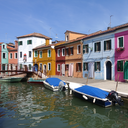

In [17]:
    image = media.read_image('https://github.com/hhoppe/data/raw/main/image.png')
    print(image.shape, image.dtype)  # It is a numpy array.
    media.show_image(image)